# LSST Simulated False Detections

This notebook contains a False Detection generator for the LSST opsim based Sythetic Solar System Object Observation Catalog. The notebook is based on Jones et al. (2018) and Veres & Chesley (2017).

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import sqlite3 as sql

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [5]:
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [6]:
from lsst.sims.utils import ObservationMetaData
from lsst.sims.coordUtils import lsst_camera
from lsst.sims.coordUtils import chipNameFromRaDecLSST
from lsst.afw.cameraGeom import DetectorType

In [47]:
def sampleFOV(npoints, center, rFOV=0.01, ndim=3, seed=2020):
    """Sample n points randomly (uniform distribution) on a region on the unit (hyper-)sphere.
    
    Parameters:
    -----------
    npoints ... number of sampled points
    center  ... center of hpyer-sphere
    rFOV    ... radius on unit sphere [radians]
    ndim    ... dimension of hyper-sphere
    seed    ... random seed
    
    Returns:
    --------
    vec ... numpy array of npoints x ndim vectors 
    """
    
    np.random.seed(seed)
    randn = np.random.randn
    norm = np.linalg.norm
    select = np.random.choice
    where = np.where
    
    # create a hypercube with int(4pi/3)+2 * npoints points
    cube = randn(ndim, 7*npoints).T
    cube_norm = norm(cube, axis=1)
    
    # select npoints points within a unit sphere and scale to rFOV
    mini_sphere = cube[select(where(cube_norm <= 1.)[0],npoints,replace=False)]*rFOV
    
    # change sphere center to center point on the celestial sphere
    mini_sphere+=center

    # project mini_sphere onto celestial sphere
    [x,y,z] = [mini_sphere[:,0],mini_sphere[:,1],mini_sphere[:,2]]/norm(mini_sphere, axis=1)
    vec=np.array([x,y,z])
    return vec.T

In [8]:
def diaFalseDetectionVmag(nNoise, Vlim, eta0=5):
    """Noise V magnitude of Difference Imaging Artefacts following Veres & Chesley (2017).
    
    Parameters:
    -----------
    nNoise ... number of artifacts
    Vlim   ... m5 liming magntide at eta0=5
    eta0   ... Signal To Noise ratio limit for detection 
    
    Returns:
    --------
    V ... array containing nNoise Vmag values
    """
    
    p=np.random.random_sample(nNoise)
    eta = eta0*(1./(1.-p)**2)**(1./3.)
    V = Vlim - 2.5*np.log(eta/eta0)
    
    return V

In [9]:
def radec2icrfu(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
       
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)

    return array([x, y, z])
   

In [10]:
def icrf2radec(x, y, z, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    x,y,z ... 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    pos=array([x,y,z])
    if(pos.ndim>1):
        r=norm(pos,axis=0)
    else:
        r=norm(pos)
    
    xu=x/r
    yu=y/r
    zu=z/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
        
    return ra, dec

In [11]:
def cameraFootprintFilter(ephems,obsdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos',
                         raNameEph='AstRA(deg)',decNameEph='AstDec(deg)',
                         obsIdNameEph='observationId'):
    
    """LSST Cam footprint filter. Filter RADEC observation 
    data bases for observations that do not fall on science chips on the camera.
    
    Parameters:
    ----------- 
    ephems ... observations containing RA and Dec data
    obsdf  ... opsim database (pandas dataFrame)

    Returns:
    ephemsOut ... filtered observations
    """
    

    camera = lsst_camera()
    ccd_type_dict = {DetectorType.SCIENCE: 'science', DetectorType.WAVEFRONT: 'wavefront',
                 DetectorType.GUIDER: 'guider', DetectorType.FOCUS: 'focus'}
    
    ephemsFiltered=[]
    i=0
    for index, row in obsdf.iterrows(): 

        obs_metadata = ObservationMetaData(pointingRA=row[raname],
                                           pointingDec=row[decname],
                                           rotSkyPos=row[rotskyname],
                                           mjd=row[obsepochname])

        ephems_sel=ephems[ephems[obsIdNameEph] == row[obsIdname]].reset_index(drop=True)

        
        chipName = chipNameFromRaDecLSST(ra=ephems_sel[raNameEph].values.astype(float),
                                         dec=ephems_sel[decNameEph].values.astype(float),
                                            epoch=2000.0, obs_metadata=obs_metadata)


        idx=np.where(chipName != None)[0]
        idxObs=[i for i in idx if (ccd_type_dict[camera[chipName[i]].getType()] == 'science')]
        ephemsFiltered.append(ephems_sel[ephems_sel.index.isin(idxObs)])
    
    ephemsOut=pd.concat(ephemsFiltered).reset_index(drop=True)
    return ephemsOut

In [12]:
def getSqlData(database,rows_start,nrows):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql("""SELECT * FROM SummaryAllProps LIMIT """+str(rows_start)+','+str(nrows), con)
    return observations

In [13]:
def makeFalseDetectionsFiles(rowStart,nRows, db_path, seed=2020):
    """Generate False Detections due to Difference Image Artifacts 
    for a given opsim survey simulation and save them as csv files.
    
    Parameters:
    -----------
    rowStart    ... start row of opsim SQL data base
    nRows       ... how many rows should be processed
    db_path     ... path to opsim SQL data base
    seed        ... random seed
    """
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440, seed=seed)
    FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/false_detections_fbs-v1_7_1-'+str(rowStart).zfill(7)+'.csv'
    FDFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [14]:
def makeRandomNoiseFiles(rowStart,nRows,db_path, seed=1990):
    """Generate False Detections from random noise for a given opsim survey 
    simulation and save them as csv files.
    
    Parameters:
    -----------
    rowStart    ... start row of opsim SQL data base
    nRows       ... how many rows should be processed
    db_path     ... path to opsim SQL data base
    seed        ... random seed
    """
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    NSdf, nNSlist=createRandomNoise(LSSTdf,nLim=1000,seed=seed)
    NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/random_noise_fbs-v1_7_1-'+str(rowStart).zfill(7)+'.csv'
    NSFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [15]:
def flux2mag(f,  f0=3631):
    """AB ugriz system (f0 = 3631 Jy) to magnitude conversion

       Parameters:
       -----------
       f  ... flux [Jy]
       f0 ... zero point flux
   
       Returns:
       --------
       mag ... pogson magnitude
    """
    mag=-2.5*np.log10(f/f0)
    
    return mag

In [16]:
def calcAstrometricError(mag, m5, nvisit=1, FWHMeff=700.0, error_sys = 10.0, astErrCoeff=0.60, output_units='mas'):
    """Calculate the astrometric error, for object catalog purposes.
    The effective FWHMeff MUST BE given in miliarcsec (NOT arcsec!).
    Systematic error, error_sys, must be given in miliarcsec.
    
    Parameters:
    -----------
        mag            ...    magnitude of the observation
        m5             ...    5 sigma limiting magnitude
        nvisit         ...    number of visits to consider
        FWHMeff        ...    effective Full Width at Half Maximum of Point Spread Function [mas]
        error_sys      ...    sytstematic error [mas]
        output_units   ...    'mas' (default): milliarcseconds, 'arcsec': arcseconds
    
    Returns:
    ---------
        astrom_error   ...    astrometric error 
        SNR            ...    signal to noise ratio
        error_rand     ...    random error
        
    *** This error corresponds to a single-coordinate error ***
    the total astrometric error (e.g. relevant when
    matching two catalogs) will be sqrt(2) times larger!
    """
    # The astrometric error can be applied to parallax or proper motion (for nvisit>1).
    # If applying to proper motion, should also divide by the # of years of the survey.
    # This is also referenced in the LSST overview paper (arXiv:0805.2366, ls.st/lop)
    #
    # Notes:
    # - assumes sqrt(Nvisit) scaling, which is the best-case scenario
    # - calcRandomAstrometricError assumes maxiumm likelihood solution,
    # which is also the best-case scenario
    # - the systematic error, error_sys = 10 mas, corresponds to the
    # design spec from the LSST Science Requirements Document (ls.st/srd)
    #
    # first compute SNR
    
    power=np.power
    sqrt=np.sqrt
    
    
    rgamma = 0.039
    xval = power(10, 0.4*(mag-m5))
    SNR = 1./sqrt((0.04-rgamma)*xval + rgamma*xval*xval)
    # random astrometric error for a single visit
    error_rand = calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, astErrCoeff)
    # random astrometric error for nvisit observations
    if (nvisit > 1):
        error_rand = error_rand / sqrt(nvisit)
    # add systematic error floor:
    astrom_error = sqrt(error_sys * error_sys + error_rand*error_rand)
    
    if (output_units=='arcsec'):
        astrom_error=astrom_error/1000
        error_rand=error_rand/1000
    
    return astrom_error, SNR, error_rand

def calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, AstromErrCoeff = 0.60):
    """Calculate the random astrometric error, as a function of
    effective FWHMeff and signal-to-noise ratio SNR
    Returns astrometric error in the same units as FWHM.
    ** This error corresponds to a single-coordinate error **
    the total astrometric error (e.g. relevant when matching
    two catalogs) will be sqrt(2) times larger.

    The coefficient AstromErrCoeff for Maximum Likelihood
    solution is given by 
       AstromErrCoeff = <P^2> / <|dP/dx|^2> * 1/FWHMeff
    where P is the point spread function, P(x,y). 

    For a single-Gaussian PSF, AstromErrCoeff = 0.60
    For a double-Gaussian approximation to Kolmogorov 
    seeing, AstromErrCoeff = 0.55; however, given the 
    same core seeing (FWHMgeom) as for a single-Gaussian
    PSF, the resulting error will be 36% larger because
    FWHMeff is 1.22 times larger and SNR is 1.22 times
    smaller, compared to error for single-Gaussian PSF.
    Although Kolmogorov seeing is a much better approximation
    of the free atmospheric seeing than single Gaussian seeing, 
    the default value of AstromErrCoeff is set to the
    more conservative value.
    Note also that AstromErrCoeff = 1.0 is often used in
    practice to empirically account for other error sources.

    The <June2020 version of this code used AstromErrCoeff=1.0
    and FWHMgeom instead of FWHMeff. Given that 
    FWHMeff/FWHMgeom=1.22 for Kolmogorov seeing, the old 
    version was within 3% from the total astrometric error 
    (that is, not error per coordinate, but sqrt(2) larger)
    produced with this updated version.
    """
    return AstromErrCoeff * FWHMeff / SNR 

def magErrorFromSNR(snr):
    """
    convert flux signal to noise ratio to an error in magnitude
    @param [in] snr is the signal to noise ratio in flux
    @param [out] the resulting error in magnitude
    """

    log10=np.log10
    
    #see www.ucolick.org/~bolte/AY257/s_n.pdf section 3.1
    return 2.5*log10(1.0+1.0/snr)

In [17]:
def NrandomNoise(seeingFWHM=1, S=4000*4000, SNR=5,  arcsec_per_pixel=0.2):
    """ LSST detector random noise model (Kaiser, 2004). Gives the number 
    of false detections due to Gaussian random fluctuations in the sky background 
    and detector noise for a given SNR.
    
    Parameters:
    -----------
    seeingFWHM      ... seeing Full Width Half Maximum in arcsec
    S               ... total number of pixels on sensor (ncols*nrows)
    SNR             ... signal-to-noise threshold for detection (e.g. 5)
    arcsec_per_pixel... number of arcseconds per pixel
    
    Returns:
    Nfd             ... number of false detections on sensor
    """

    # sigma_g is the FWHM seeing measured in pixels 
    sigma_g = seeingFWHM/arcsec_per_pixel/2.35
    
    # Gaussian background noise,convolved with a Gaussian point spread function (PSF) 
    # with width sigma_g
    # Number of noise detections for SNRs > SNR
    Nfd = S*SNR*np.exp(-(SNR**2)/2.)/(2.**2.5*np.pi**1.5*sigma_g**2)
    return Nfd

In [18]:
def createDiaFalseDetections(obsdf, minFD=100,maxFD=800, rOnSky=2.3,
                             nFDlim=3500, seed=2020,
                             raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                             obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                             seeingName='seeingFwhmEff',filterName='filter',fieldIdName='fieldId',
                             outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                            'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                            'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                            'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                            'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                            'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated Difference Image Artifact False Detections 
    assuming a Gaussian distribution between n = minFD(-3sigma)
    and maxFD (+3 sigma) where n is the number of diaSources per 
    square degree on the sky. 
    Random RADEC positions are generated on uniformly the unit sphere. For every visit field of view 
    points within rOnSky are selected through a KDTree query. This avoids issues at celestial poles. 
    Magnitudes are drawn according to Veres & Chesley (2017). 
    The function returns circles in RA and DEC of radius rOnSky.
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    minFD             ... minimum number of DiaSources/deg^2
    maxFD             ... maximum number of DiaSources/deg^2
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) [deg] 
    nFDlim            ... limit number of False Detections per square degree
    seed              ... seed for pseudo random number generator
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    outCols           ... ouput column names
    
    Returns:
    --------
    FDdf             ... pandas DataFrame with noise positions in RADEC
    nFDlist          ... list of number of false detections per square degree for every LSST visit/exposure
    """
    
    # external:
    # NUMPY
    pi = np.pi
    normal = np.random.normal
    uniform = np.random.uniform
    rint = np.rint
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    choose = np.random.choice
    deg2rad = np.deg2rad
    array = np.array
    mean = np.mean
    std = np.std
    
    np.random.seed(seed)
 
    # PANDAS
    DataFrame = pd.DataFrame
    concat = pd.concat
    
    # initialize lists
    listdf = []
    nFDlist = []
    
    # False Detection/deg^2 statistics
    meanFD=0.5*(maxFD+minFD)
    sigmaFD=(maxFD-meanFD)/3.
    
    # Create FDs on Sky (unit sphere)
    nFDperSqDeg=3*maxFD
    sqDegInSphere=rint(360**2/pi).astype(int)

    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
    
    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x = radec2icrfu(row[raName],row[decName])

        # How many FDs do we expect in the current sky area?
        nFD = skyArea*rint(normal(loc=meanFD,scale=sigmaFD)).astype(int)
    
        # Create random sample of points in FOV 
        sample = sampleFOV(nFD,x,deg2rad(rOnSky))
        
        # convert them to RADEC
        [ra, dec] = icrf2radec(sample[:,0],sample[:,1],sample[:,2])
        radec = array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=diaFalseDetectionVmag(nFD, row[limMagName], eta0=5)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=row[seeingName]*1000, output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        # Create pandas dataFrame
        df=DataFrame(index=range(nFD),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nFD]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nFDlist.append(nFD/skyArea)

    # concatenate results dataFrame    
    FDdf=concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of False Detections per square degree', 
          int(mean(array(nFDlist))),',',int(std(array(nFDlist))))

    return FDdf, nFDlist

In [19]:
def randomNoiseVmag(nNS, m5, eta0=5, seed=1990):
    """Determine mangitude of random noise artifacts in LSST images.
    
    Parameters:
    -----------
    nNS  ... number of noise sources
    eta0 ... SNR threshold
    m5   ... limiting magnitude (5 sigma)
    
    Returns:
    --------
    Vmag ... array of V magnitudes
    """
    # external:
    # NUMPY
    np.random.seed(seed)
    uniform=np.random.uniform
    sqrt=np.sqrt
    log10=np.log10
    
    p=uniform(0,1,nNS)
    eta=sqrt(eta0**2-2.*log10(1.-p))
    Vmag=m5-2.5*log10(eta/eta0)
    return Vmag

In [20]:
def createRandomNoise(obsdf, rOnSky=2.3, nLim=1000, SNRlim=5, 
                      nPixel=4000*4000*189, arcsec_per_pixel=0.2, seed=1990,
                      raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                      obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                      seeingName='seeingFwhmEff',filterName='filter',fieldIdName='fieldId',
                      outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                     'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                     'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                     'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                     'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                     'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated random noise following Jones et al. (2018) and Veres & Chesley (2017). 
    Random RADEC positions are generated on uniformly the unit sphere. For every visit field of view 
    points within rOnSky are selected through a KDTree query. This avoids issues at celestial poles. 
    Magnitudes are drawn according to Veres & Chesley (2017).
    
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) [deg]
    nLim              ... limit number of noise sources per square degree
    nPixel            ... number of pixels in camera
    seed              ... seed for pseudo random number generator
    arcsec_per_pixel  ... arcseconds per pixel
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    outCols           ... output column names
    
    Returns:
    --------
    NSdf             ... pandas DataFrame with noise positions in RADEC
    nNSlist          ... list of number of noise detections per square degree for every LSST visit/exposure
    
    """
    
    # external:
    # NUMPY
    pi=np.pi
    normal=np.random.normal
    uniform=np.random.uniform
    rint=np.rint
    sin=np.sin
    cos=np.cos
    sqrt=np.sqrt
    choose=np.random.choice
    deg2rad=np.deg2rad
    array=np.array
    mean=np.mean
    std=np.std
    
    np.random.seed(seed)
    
    # PANDAS
    DataFrame = pd.DataFrame
    concat = pd.concat
 
    listdf = []
    nNSlist = []
    
    # Create FDs on Sky (unit sphere)
    sqDegInSphere=rint(360**2/pi).astype(int)
    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
  
    nLimFOV=rint(skyArea*nLim).astype(int)

    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x=radec2icrfu(row[raName],row[decName])
        
        # How many NS sources do we expect in the current sky area?
        nNS=rint(NrandomNoise(seeingFWHM=row[seeingName], S=nPixel, SNR=5, 
                        arcsec_per_pixel=0.2)).astype(int)
        if(nNS>nLimFOV):
            print('nNS/deg^2>nLim:',nNS/skyArea,nLim)
            print('seeing:',row[seeingName])
            nNS=nLimFOV

        sample=sampleFOV(nNS,x,deg2rad(rOnSky), seed=seed)
        
        [ra, dec]=icrf2radec(sample[:,0],sample[:,1],sample[:,2])
    
        radec=array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=randomNoiseVmag(nNS, row[limMagName], eta0=5, seed=seed+10)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=row[seeingName]*1000, output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        df=DataFrame(index=range(nNS),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nNS]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nNSlist.append(nNS/skyArea)

    NSdf=concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of random noise per square degree', 
          int(mean(array(nFDlist))/skyArea),',',int(std(array(nFDlist))/skyArea))

    return NSdf, nNSlist

In [21]:
def plotFilteredFootprint(df, dfFiltered, raName='AstRA(deg)', decName='AstDec(deg)', title='LSST CAM Field',
                         label1='FD sample',label2='FDs footprint filtered'):
    """Compare filtered camera footprint with circular stamp."""
    plt.figure(dpi=300, figsize=(6,6))
    plt.scatter(df[raName],df[decName],s=0.04,label=label1)
    plt.scatter(dfFiltered[raName],dfFiltered[decName],s=0.02,label=label2)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.title(title)
    plt.legend()
    plt.show()

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [22]:
#db_path="../opsim/baseline_2snaps_v1.5_10yrs.db"
db_path="../opsim/baseline_nexp2_v1.7.1_10yrs.db"

Select the first ten exposures of the LSST survey for testing purposes

In [23]:
LSSTdf=getSqlData(db_path,0,10)

In [24]:
LSSTdf

observationId     fieldRA  fieldDec  observationStartMJD  flush_by_mjd  \
0              0  299.514699 -4.670462         59853.985644           0.0   
1              1  301.978025 -2.728141         59853.986092           0.0   
2              2  301.388735 -0.024061         59853.986539           0.0   
3              3  298.330258  0.734934         59853.986989           0.0   
4              4  300.801528  2.671025         59853.987436           0.0   
5              5  297.734708  3.424593         59853.987885           0.0   
6              6  294.696105  4.470982         59853.988334           0.0   
7              7  292.300782  2.934412         59853.988780           0.0   
8              8  295.274804  1.688773         59853.989229           0.0   
9              9  295.864474 -1.054837         59853.989678           0.0   

   visitExposureTime filter   rotSkyPos  numExposures   airmass  ...  \
0               30.0      i  185.125819             2  1.113329  ...   
1               30.0      i  182.832684             2  1.135953  ...   
2               30.0      i  185.087150             2  1.164352  ...   
3               30.0      i  190.600383             2  1.168102  ...   
4               30.0      i  187.261037             2  1.196699  ...   
5               30.0      i  192.392821             2  1.202458  ...   
6               30.0      i  197.333143             2  1.216760  ...   
7               30.0      i  201.412412             2  1.197196  ...   
8               30.0      i  197.034767             2  1.178427  ...   
9               30.0      i  196.382880             2  1.145481  ...   

       moonAz       sunAz     sunRA    sunDec      moonRA    moonDec  \
0  269.499448  258.357865  3.277205 -0.058536  263.929527 -26.677289   
1  269.441746  258.270824  3.277212 -0.058539  263.934291 -26.677432   
2  269.383861  258.183514  3.277219 -0.058542  263.939065 -26.677572   
3  269.325622  258.095676  3.277226 -0.058545  263.943865 -26.677709   
4  269.267690  258.008307  3.277233 -0.058548  263.948634 -26.677844   
5  269.209342  257.920314  3.277240 -0.058551  263.953433 -26.677976   
6  269.150946  257.832254  3.277247 -0.058554  263.958232 -26.678105   
7  269.092698  257.744418  3.277254 -0.058557  263.963014 -26.678231   
8  269.034110  257.656070  3.277262 -0.058560  263.967820 -26.678355   
9  268.975380  257.567510  3.277269 -0.058563  263.972633 -26.678477   

   moonDistance  solarElong  moonPhase  cummTelAz  
0     40.463090  111.336532  42.296597  12.322046  
1     43.591223  113.959648  42.298719  16.798283  
2     44.800491  113.573464  42.300845  14.518044  
3     42.981206  110.566373  42.302983   8.423939  
4     46.108447  113.131553  42.305107  12.601840  
5     44.394657  110.103050  42.307245   6.943710  
6     43.056863  107.114128  42.309383   1.527547  
7     40.319479  104.660416  42.311514  -2.911583  
8     41.420517  107.566377  42.313655   2.442743  
9     39.933104  107.990640  42.315800   3.502640  

[10 rows x 41 columns]

Create False Detections according to Veres & Chesley (2017). 

In [25]:
FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440)

mean, sigma of number of False Detections per square degree 398 , 11


In [26]:
FDdf

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  59853.985644          NaN                NaN   
1        FD              0  59853.985644          NaN                NaN   
2        FD              0  59853.985644          NaN                NaN   
3        FD              0  59853.985644          NaN                NaN   
4        FD              0  59853.985644          NaN                NaN   
...     ...            ...           ...          ...                ...   
67774    FD              9  59853.989678          NaN                NaN   
67775    FD              9  59853.989678          NaN                NaN   
67776    FD              9  59853.989678          NaN                NaN   
67777    FD              9  59853.989678          NaN                NaN   
67778    FD              9  59853.989678          NaN                NaN   

      AstRA(deg) AstRARate(deg/day) AstDec(deg) AstDecRate(deg/day)  \
0        300.399                NaN    -6.46511                 NaN   
1        299.781                NaN    -6.00087                 NaN   
2         298.77                NaN    -4.60088                 NaN   
3        299.574                NaN    -4.52402                 NaN   
4        298.631                NaN    -4.25461                 NaN   
...          ...                ...         ...                 ...   
67774    296.297                NaN   -0.695977                 NaN   
67775    296.476                NaN    0.219213                 NaN   
67776    297.726                NaN   -0.998165                 NaN   
67777    296.001                NaN    0.491023                 NaN   
67778    295.574                NaN    -1.66038                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
0                     NaN                 NaN                 NaN   
1                     NaN                 NaN                 NaN   
2                     NaN                 NaN                 NaN   
3                     NaN                 NaN                 NaN   
4                     NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
67774                 NaN                 NaN                 NaN   
67775                 NaN                 NaN                 NaN   
67776                 NaN                 NaN                 NaN   
67777                 NaN                 NaN                 NaN   
67778                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstRASigma(mas)  \
0                  NaN  NaN  22.687417    NaN      i       161.483449   
1                  NaN  NaN  22.220561    NaN      i       106.057507   
2                  NaN  NaN  20.623207    NaN      i        27.688509   
3                  NaN  NaN  22.607040    NaN      i       150.157608   
4                  NaN  NaN  21.511766    NaN      i        56.852375   
...                ...  ...        ...    ...    ...              ...   
67774              NaN  NaN  20.230789    NaN      i        21.041779   
67775              NaN  NaN  22.364634    NaN      i       119.557664   
67776              NaN  NaN  21.870289    NaN      i        77.028458   
67777              NaN  NaN  21.115182    NaN      i        40.446963   
67778              NaN  NaN  22.749051    NaN      i       169.098181   

       AstDecSigma(mas)  PhotometricSigma(mag)  
0            161.483449               0.188619  
1            106.057507               0.127197  
2             27.688509               0.032508  
3            150.157608               0.176358  
4             56.852375               0.069272  
...                 ...                    ...  
67774         21.041779               0.022125  
67775        119.557664               0.135076  
67776         77.028458               0.088504  
67777         40.446963               0.0463

In [27]:
FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')

In [28]:
FDFiltered

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  59853.985644          NaN                NaN   
1        FD              0  59853.985644          NaN                NaN   
2        FD              0  59853.985644          NaN                NaN   
3        FD              0  59853.985644          NaN                NaN   
4        FD              0  59853.985644          NaN                NaN   
...     ...            ...           ...          ...                ...   
49065    FD              9  59853.989678          NaN                NaN   
49066    FD              9  59853.989678          NaN                NaN   
49067    FD              9  59853.989678          NaN                NaN   
49068    FD              9  59853.989678          NaN                NaN   
49069    FD              9  59853.989678          NaN                NaN   

      AstRA(deg) AstRARate(deg/day) AstDec(deg) AstDecRate(deg/day)  \
0        299.781                NaN    -6.00087                 NaN   
1         298.77                NaN    -4.60088                 NaN   
2        299.574                NaN    -4.52402                 NaN   
3        298.631                NaN    -4.25461                 NaN   
4        298.685                NaN    -3.03351                 NaN   
...          ...                ...         ...                 ...   
49065    296.136                NaN    -2.44189                 NaN   
49066    296.297                NaN   -0.695977                 NaN   
49067    296.476                NaN    0.219213                 NaN   
49068    296.001                NaN    0.491023                 NaN   
49069    295.574                NaN    -1.66038                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
0                     NaN                 NaN                 NaN   
1                     NaN                 NaN                 NaN   
2                     NaN                 NaN                 NaN   
3                     NaN                 NaN                 NaN   
4                     NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
49065                 NaN                 NaN                 NaN   
49066                 NaN                 NaN                 NaN   
49067                 NaN                 NaN                 NaN   
49068                 NaN                 NaN                 NaN   
49069                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstRASigma(mas)  \
0                  NaN  NaN  22.220561    NaN      i       106.057507   
1                  NaN  NaN  20.623207    NaN      i        27.688509   
2                  NaN  NaN  22.607040    NaN      i       150.157608   
3                  NaN  NaN  21.511766    NaN      i        56.852375   
4                  NaN  NaN  19.397855    NaN      i        13.861006   
...                ...  ...        ...    ...    ...              ...   
49065              NaN  NaN  22.736287    NaN      i       167.155048   
49066              NaN  NaN  20.230789    NaN      i        21.041779   
49067              NaN  NaN  22.364634    NaN      i       119.557664   
49068              NaN  NaN  21.115182    NaN      i        40.446963   
49069              NaN  NaN  22.749051    NaN      i       169.098181   

       AstDecSigma(mas)  PhotometricSigma(mag)  
0            106.057507               0.127197  
1             27.688509               0.032508  
2            150.157608               0.176358  
3             56.852375               0.069272  
4             13.861006               0.012199  
...                 ...                    ...  
49065        167.155048               0.184791  
49066         21.041779               0.022125  
49067        119.557664               0.135076  
49068         40.446963               0.0463

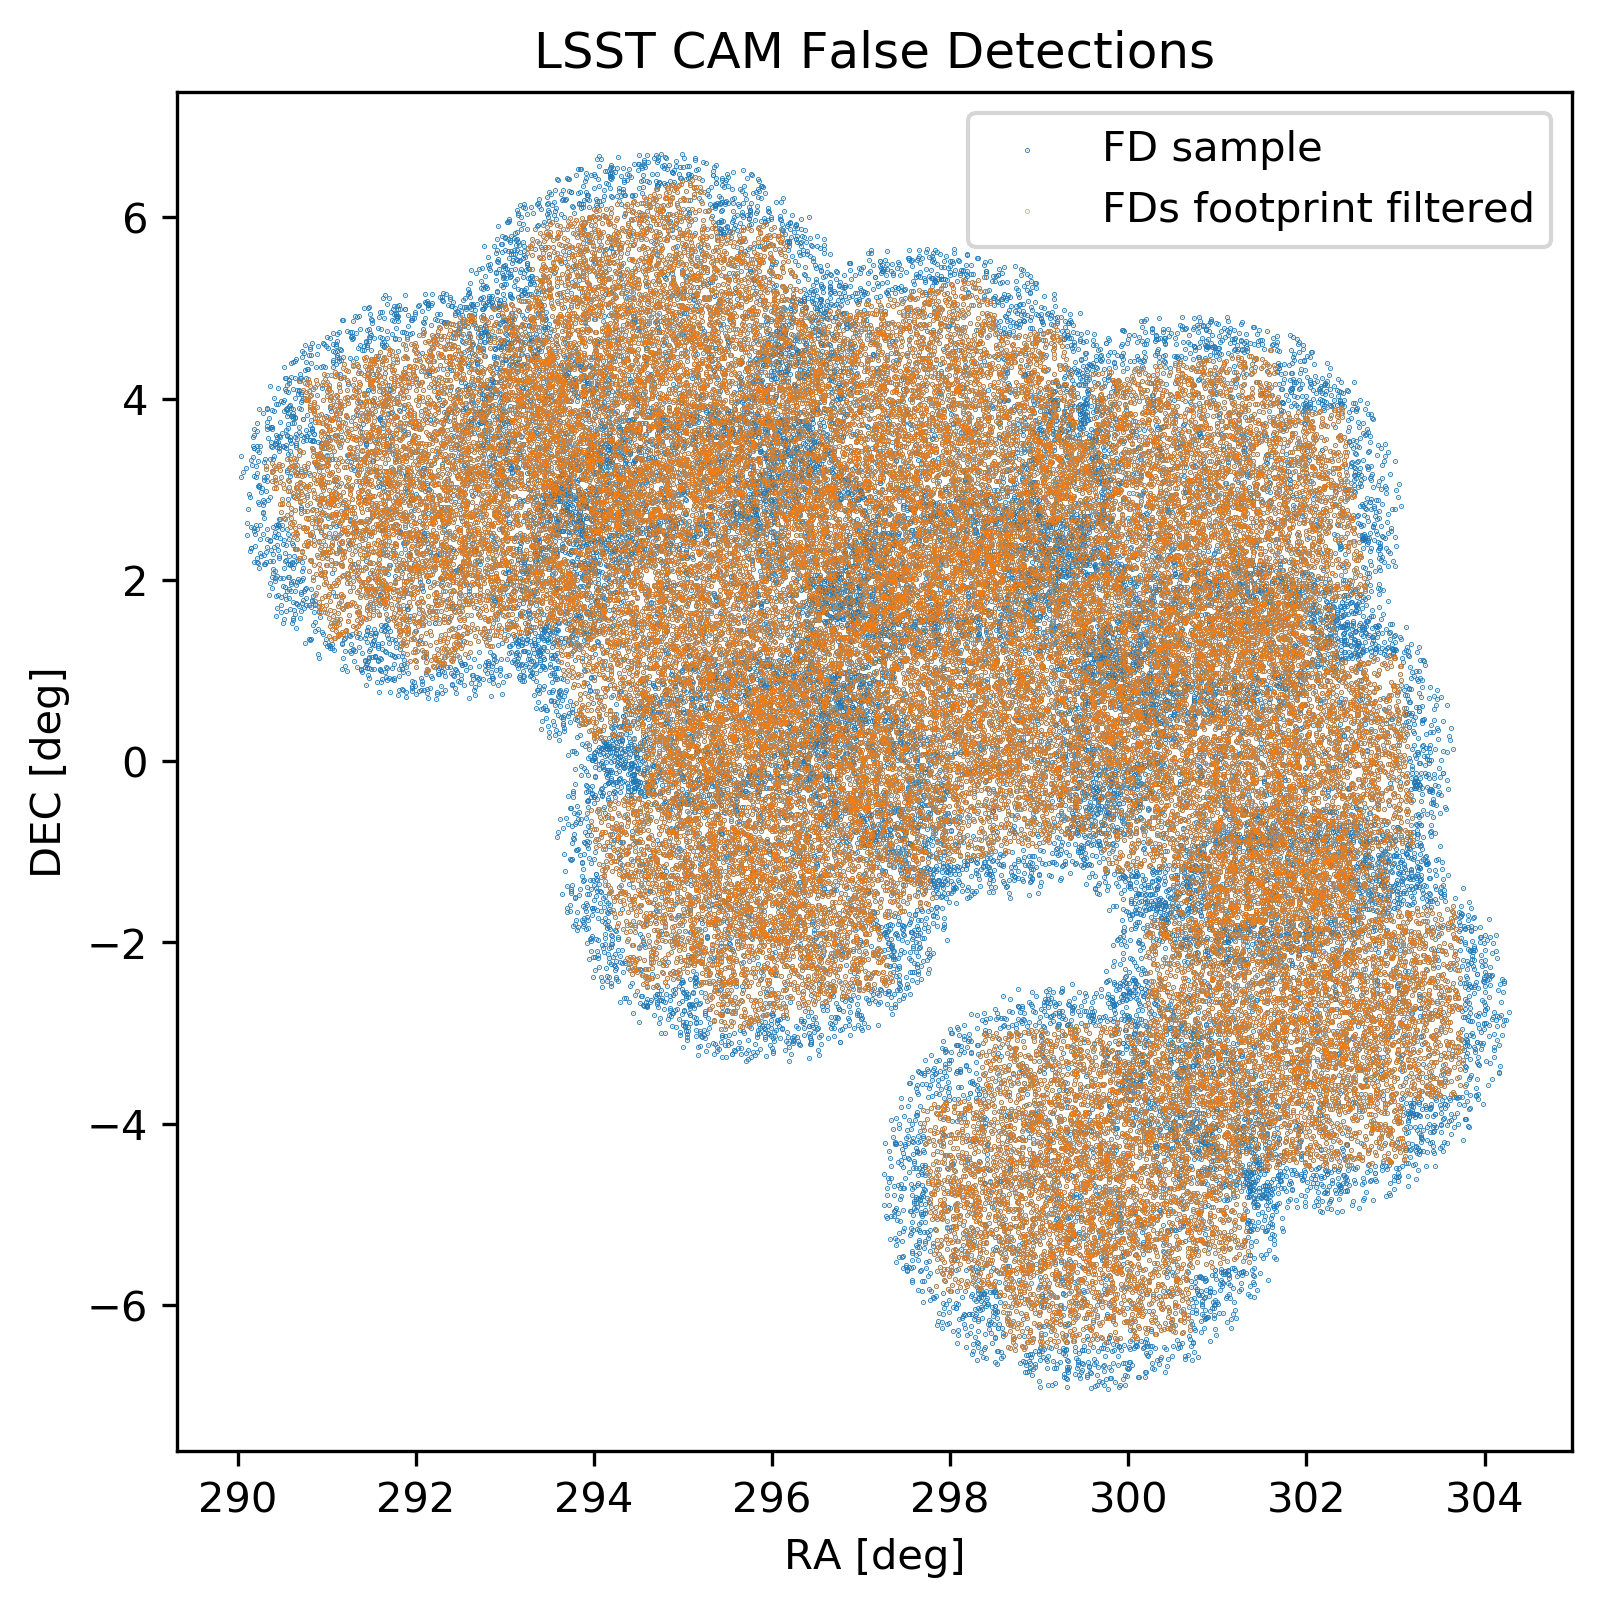

In [29]:
plotFilteredFootprint(FDdf, FDFiltered, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='LSST CAM False Detections')


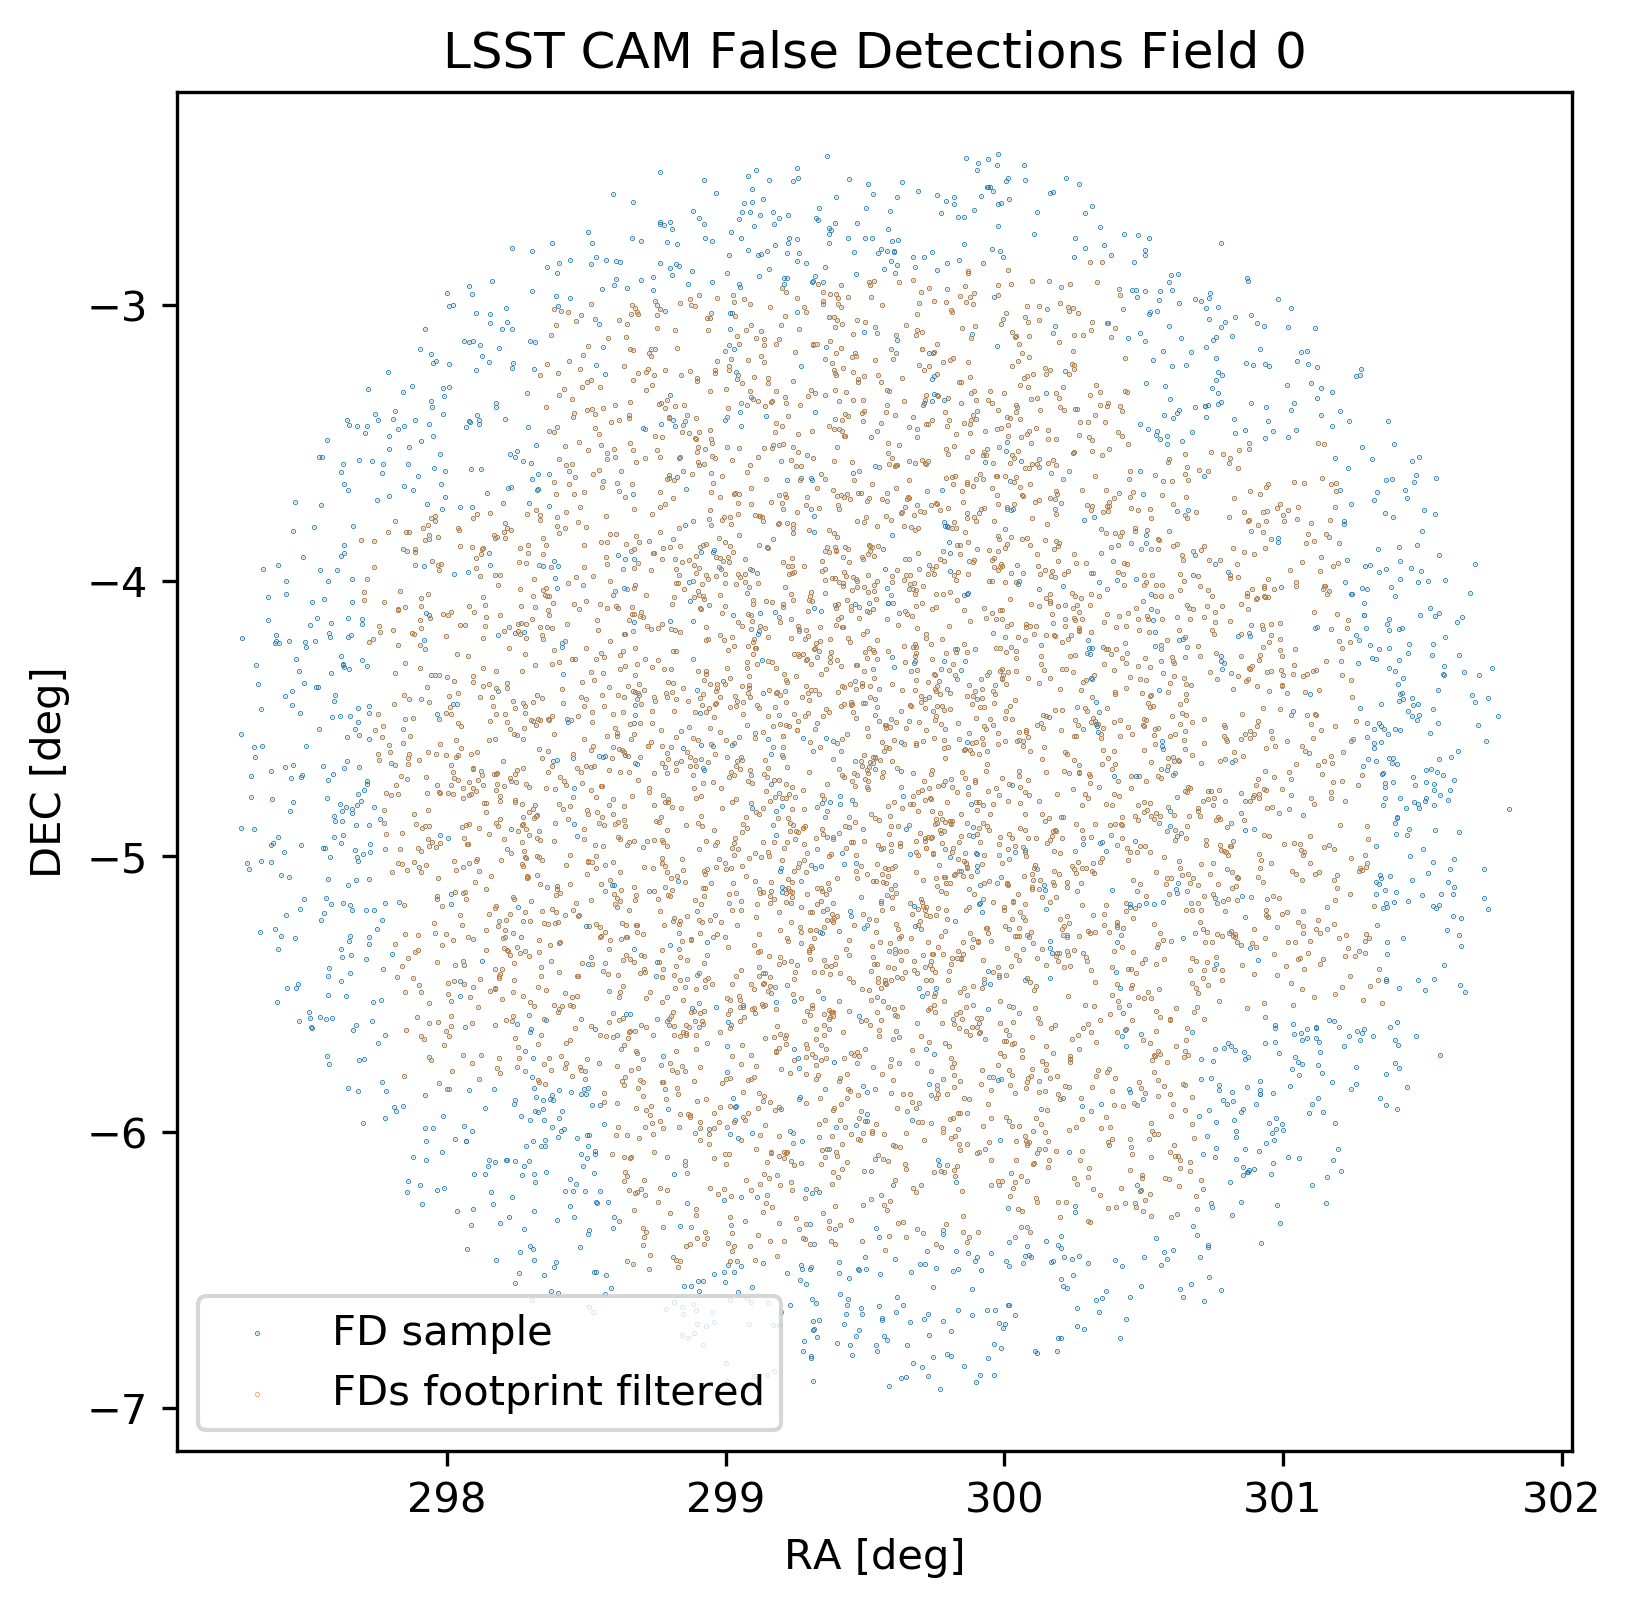

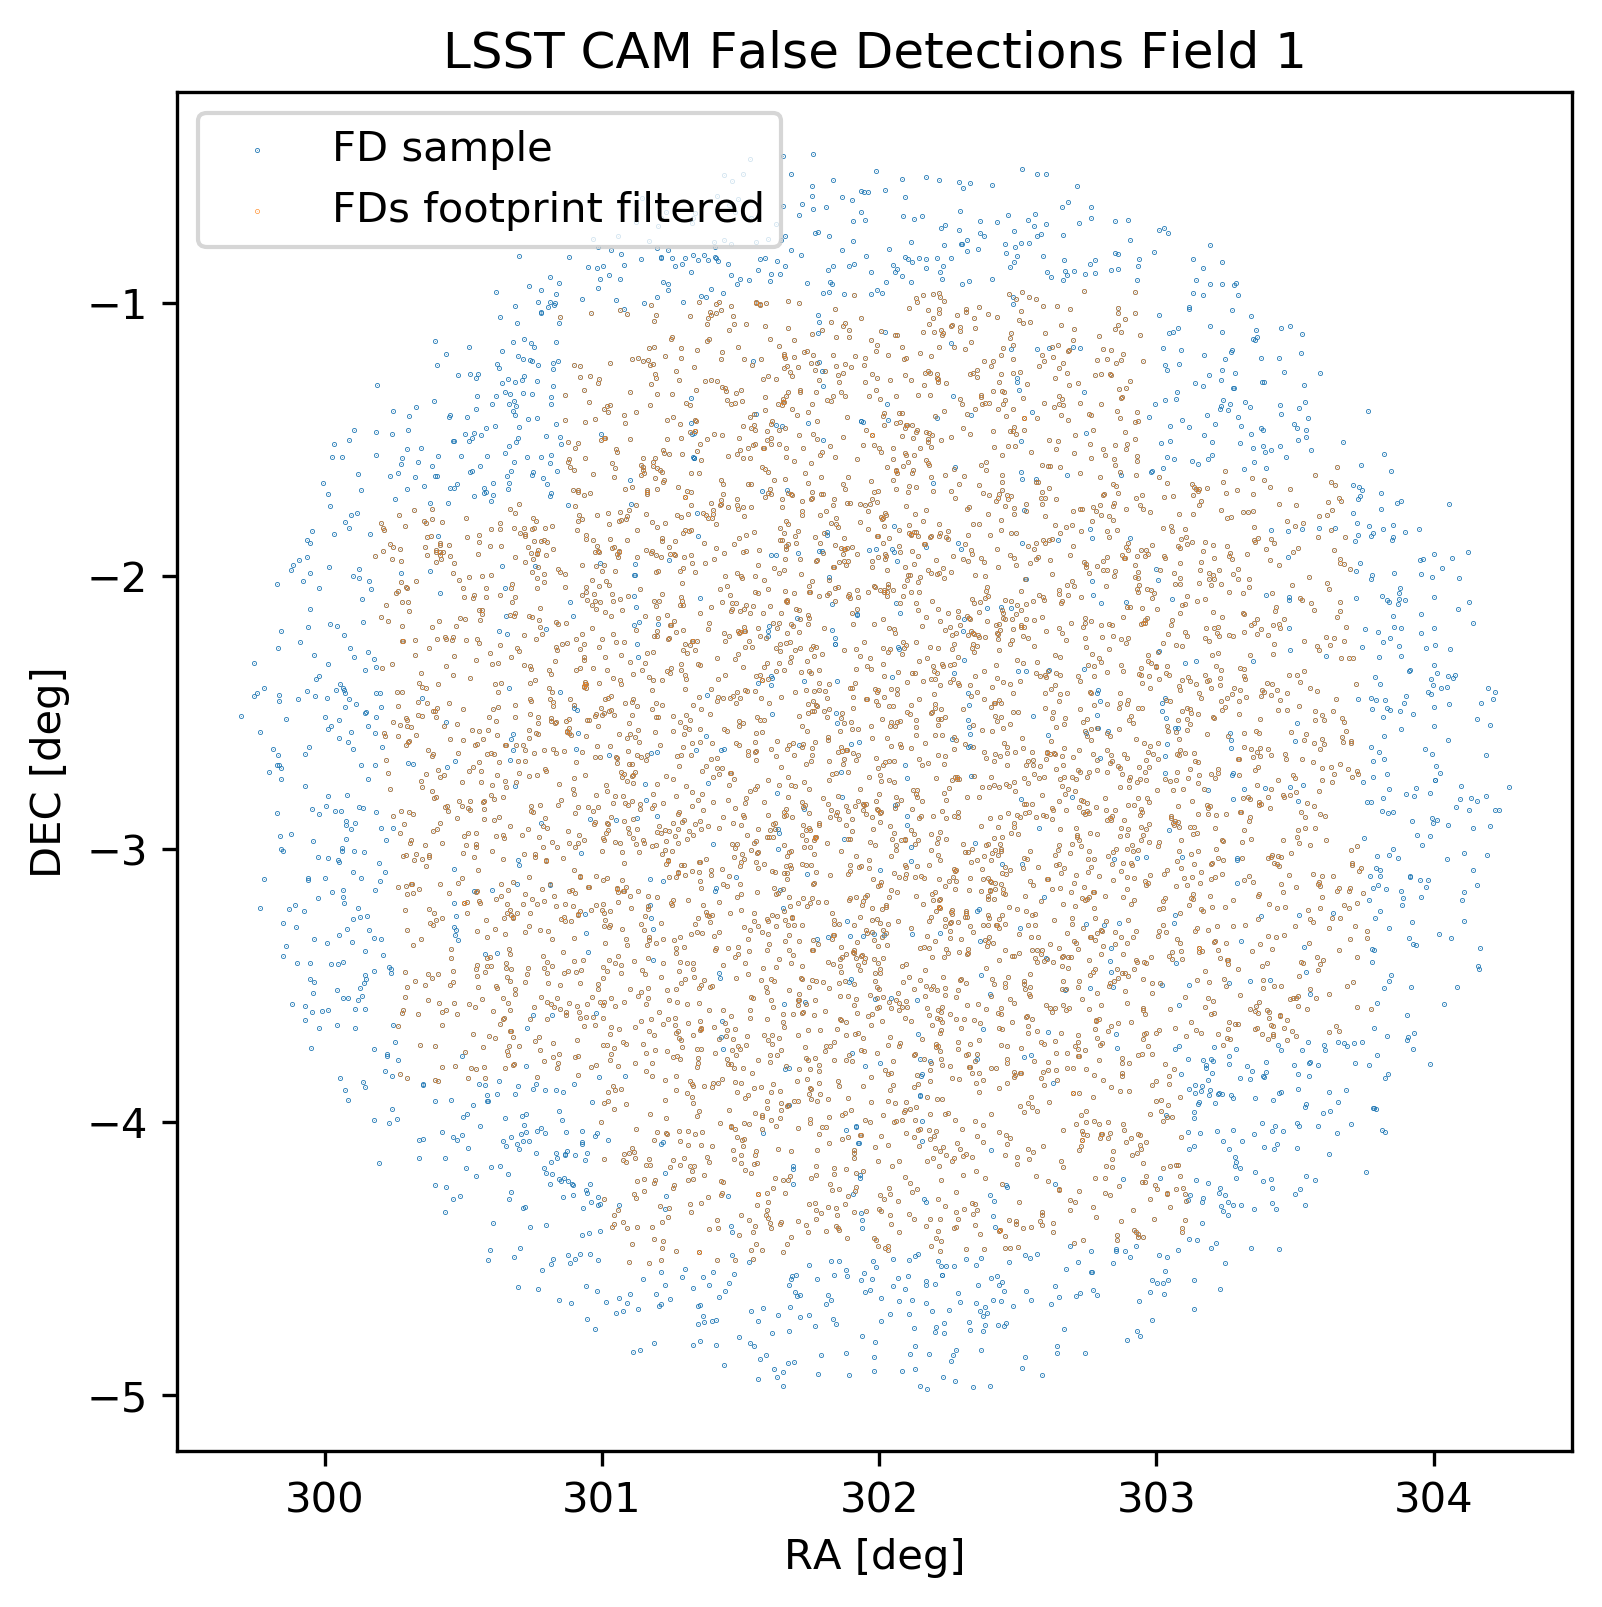

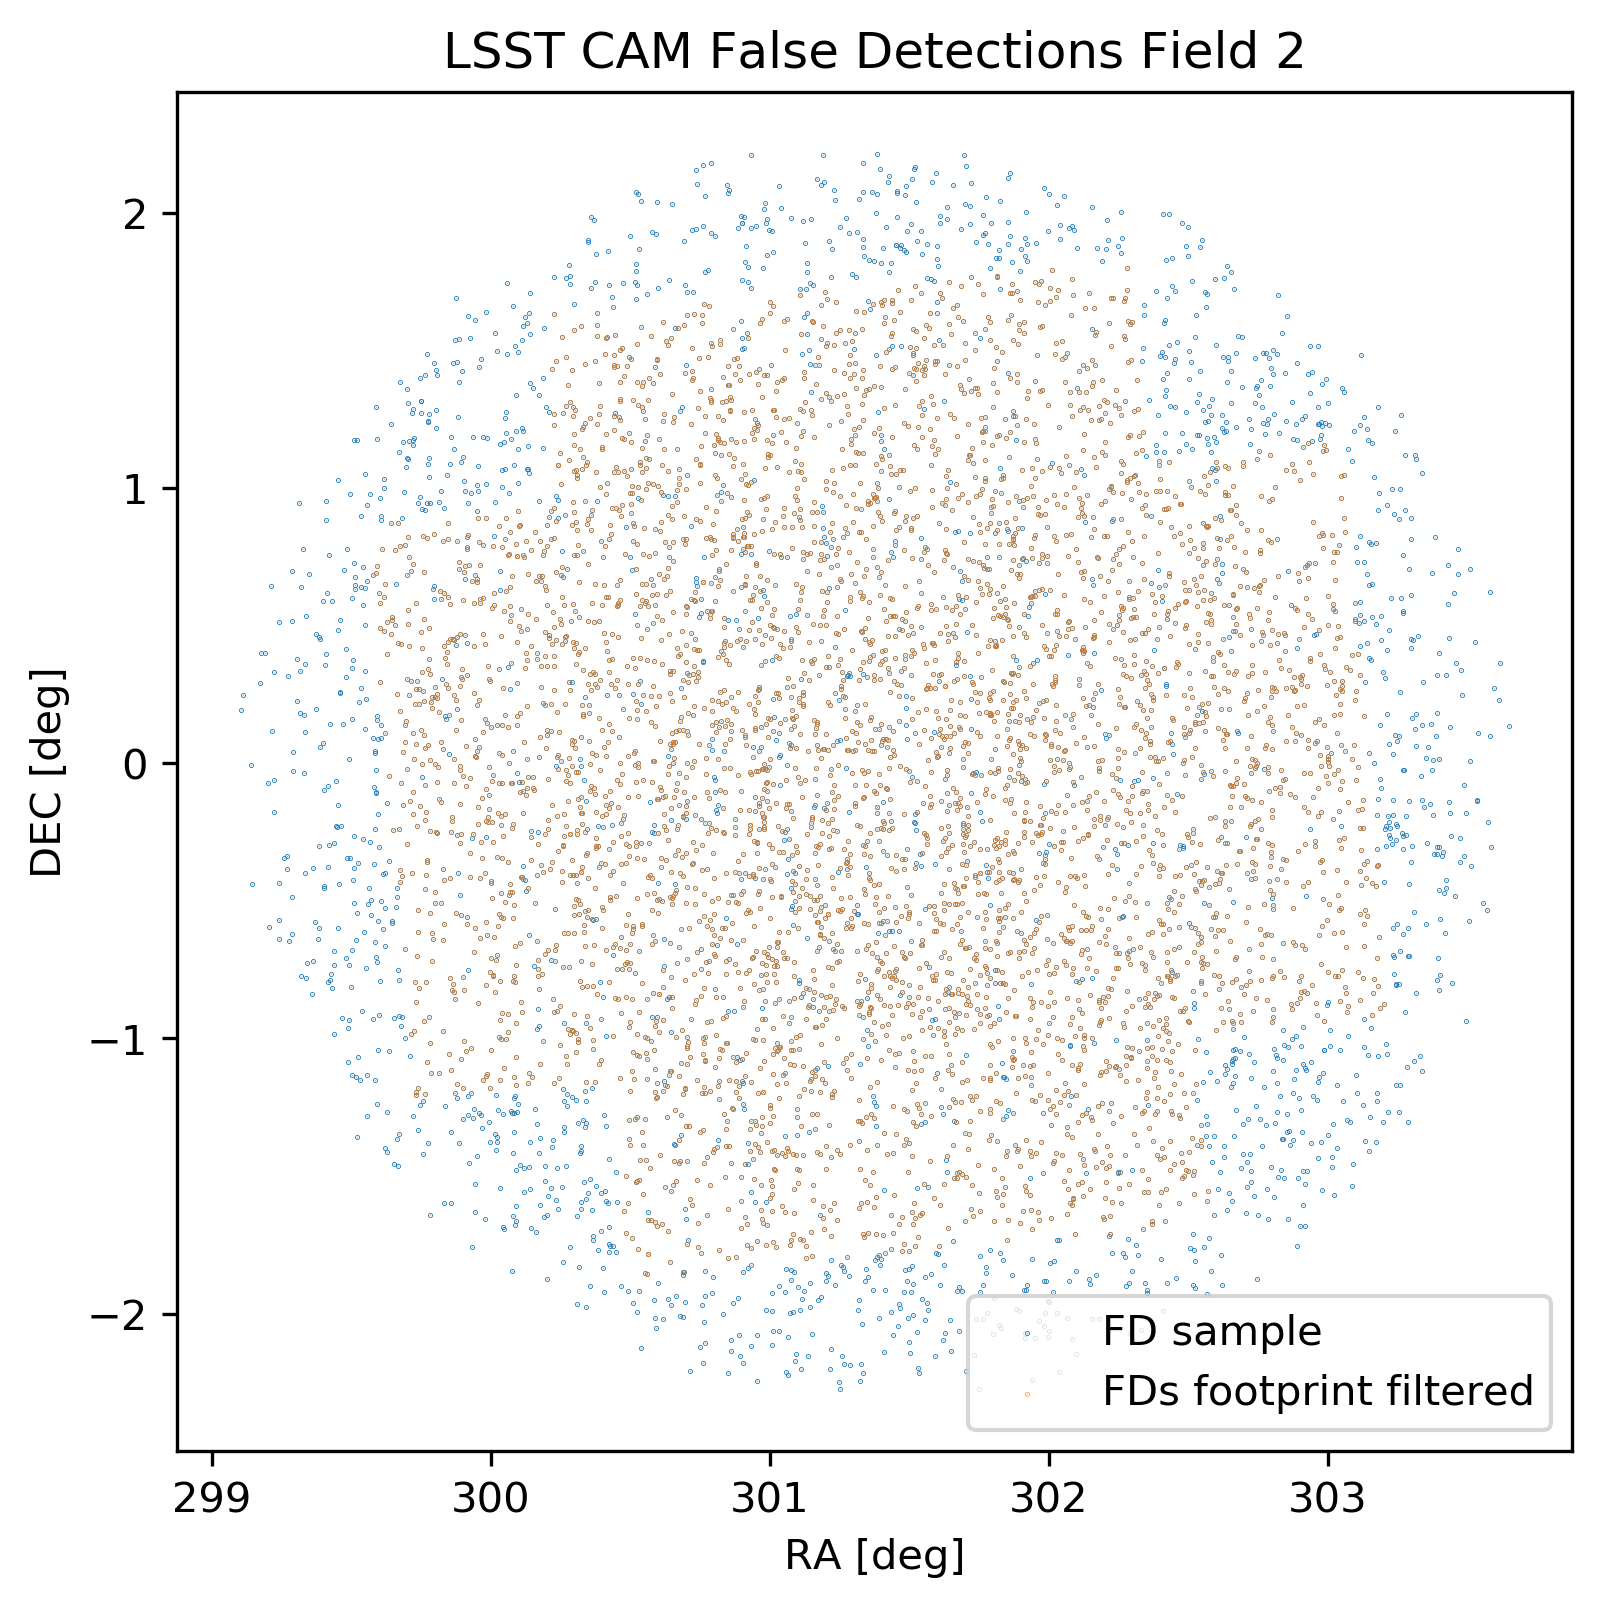

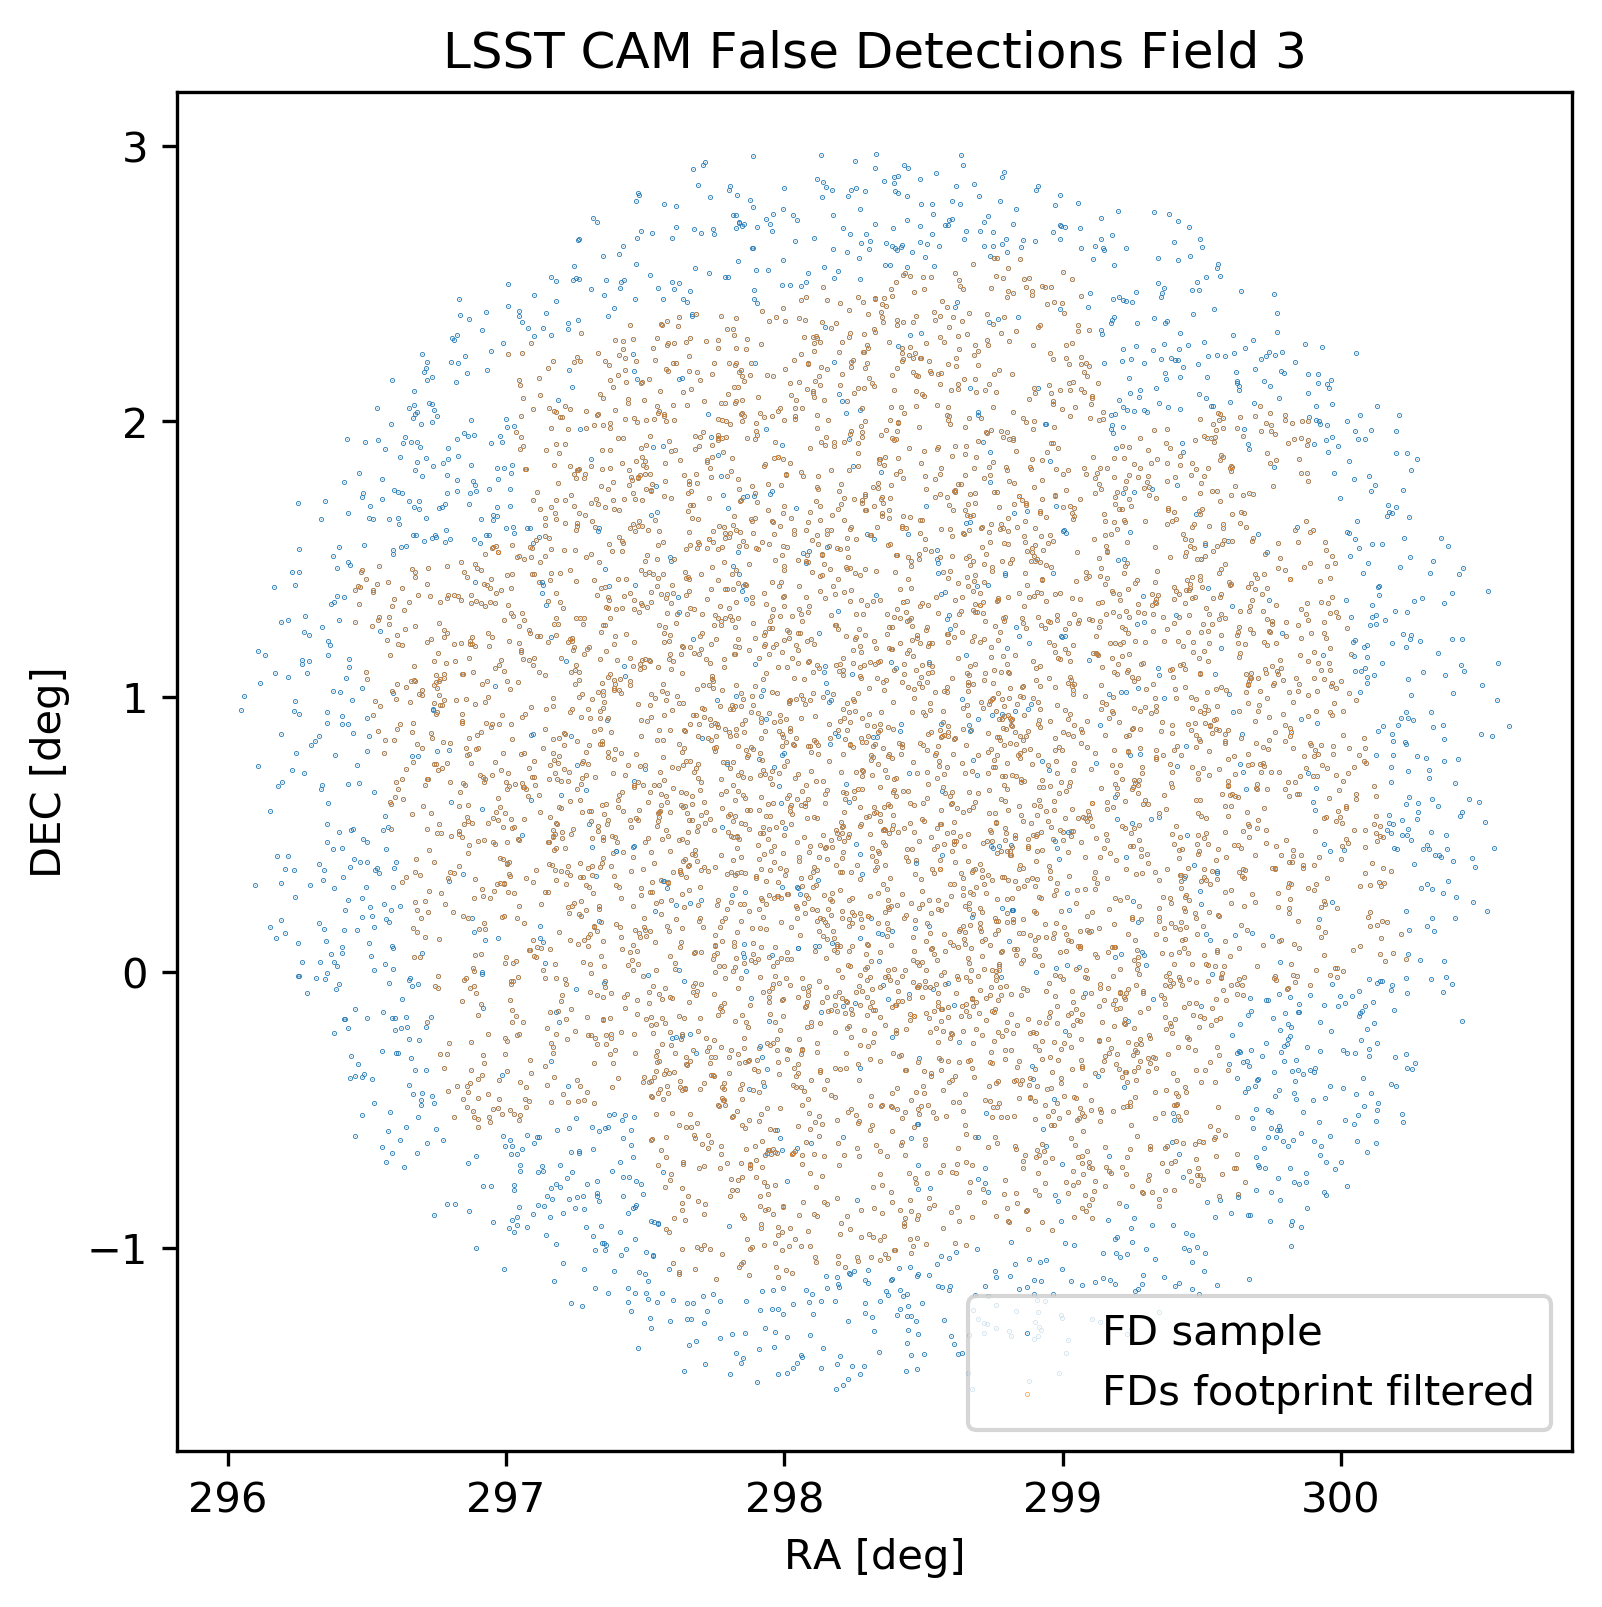

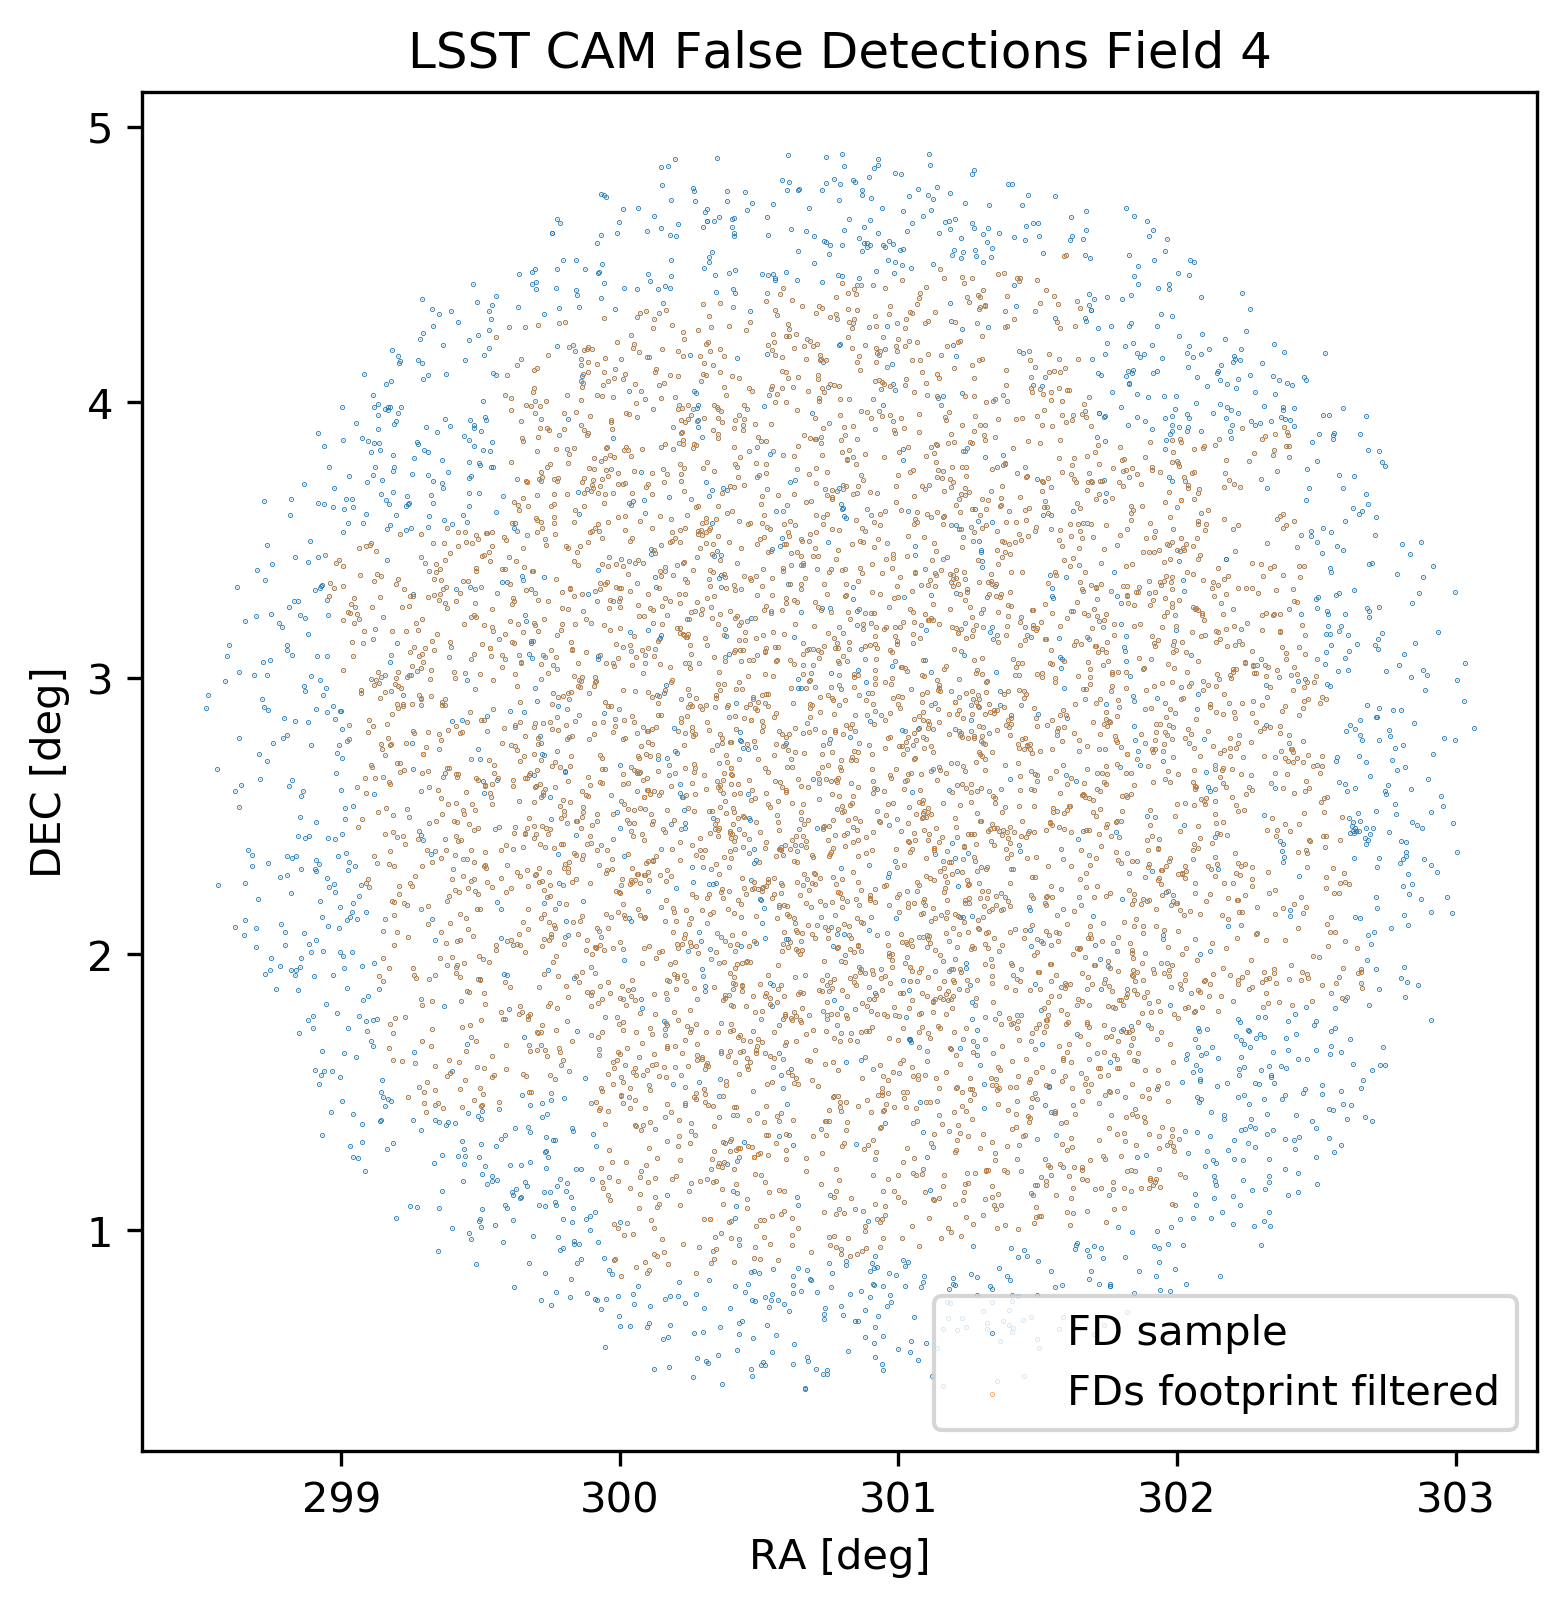

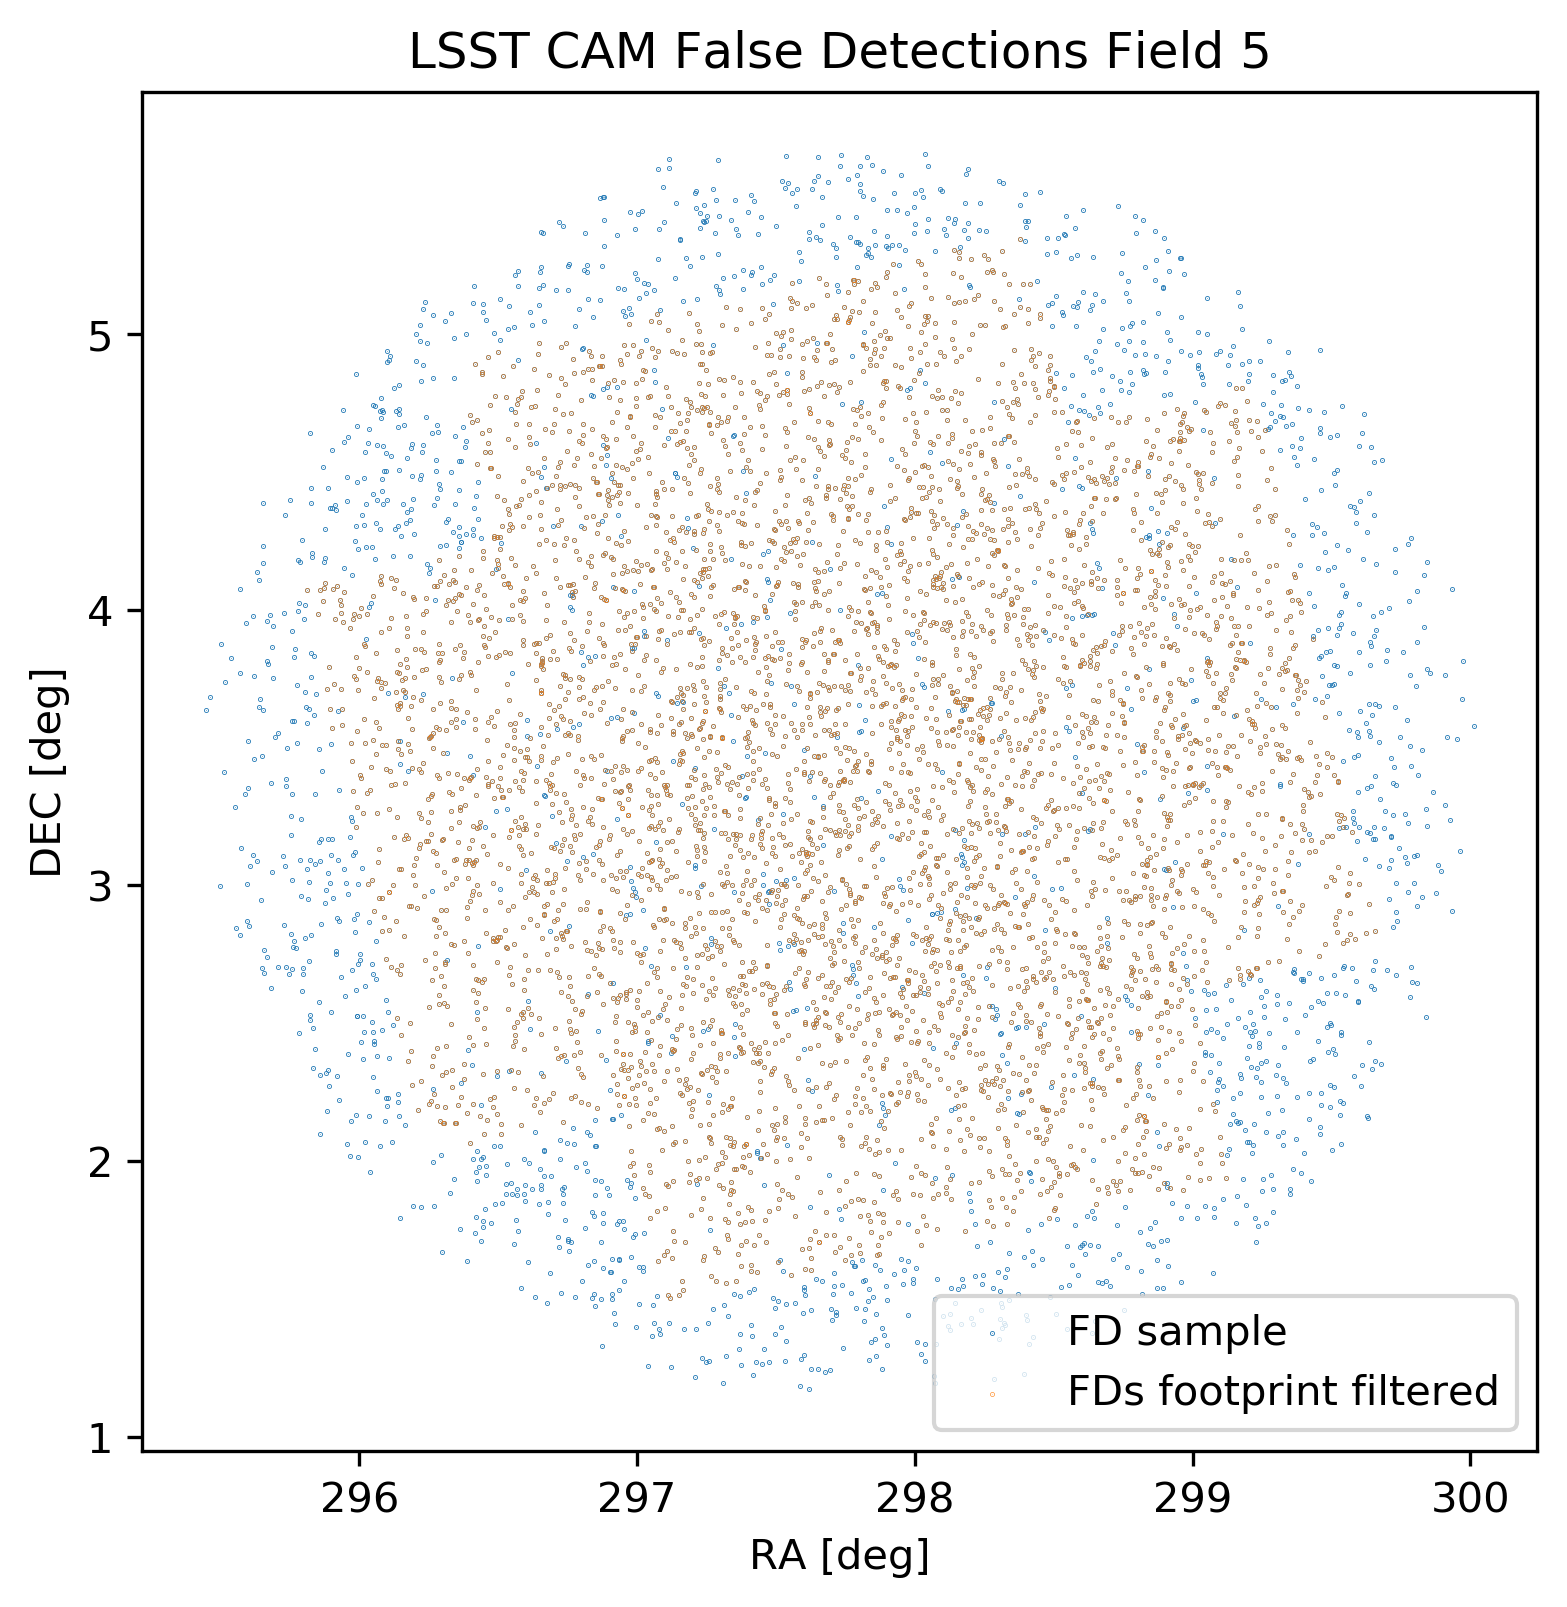

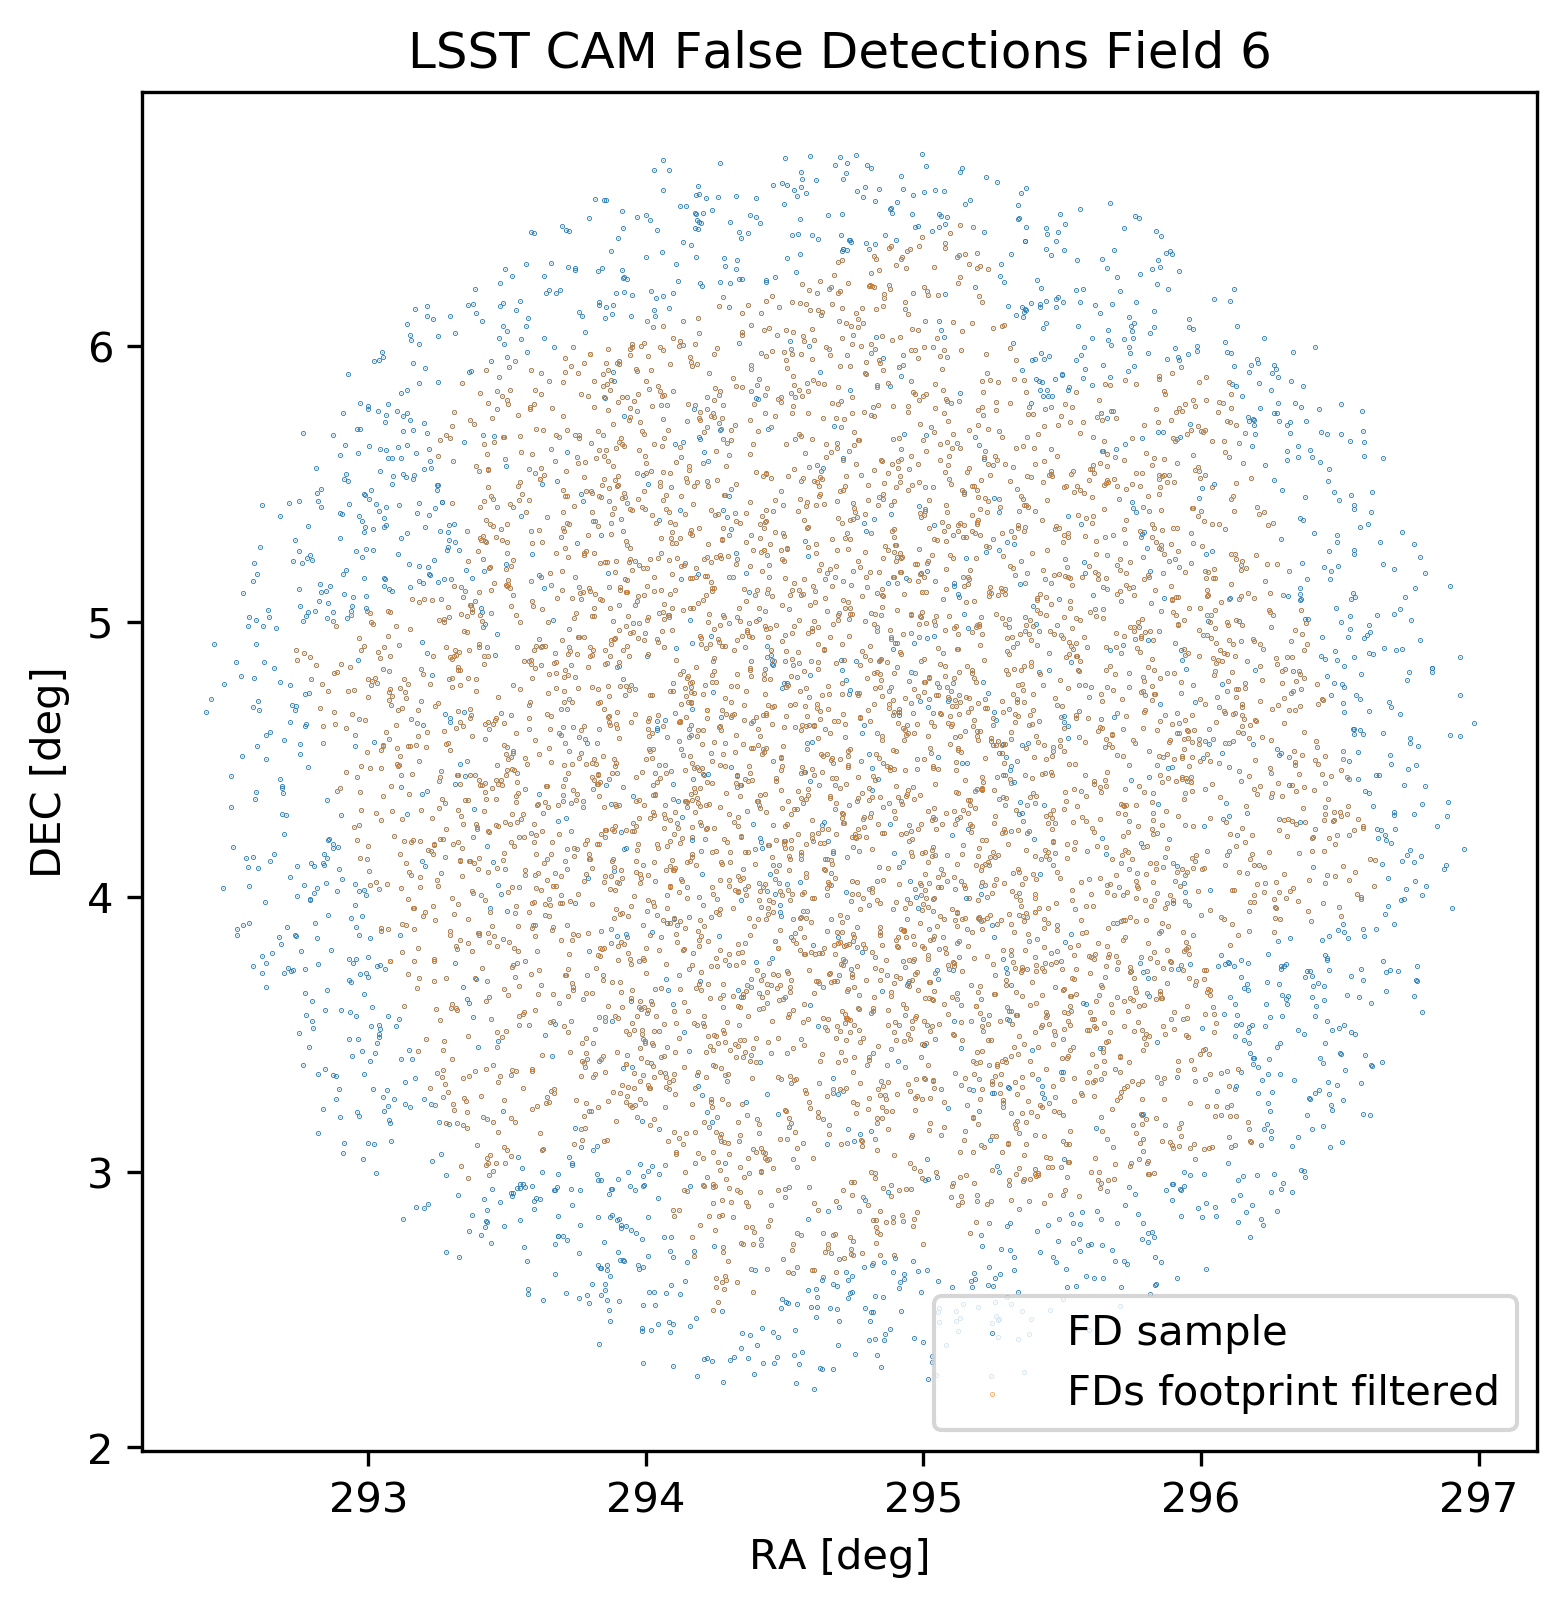

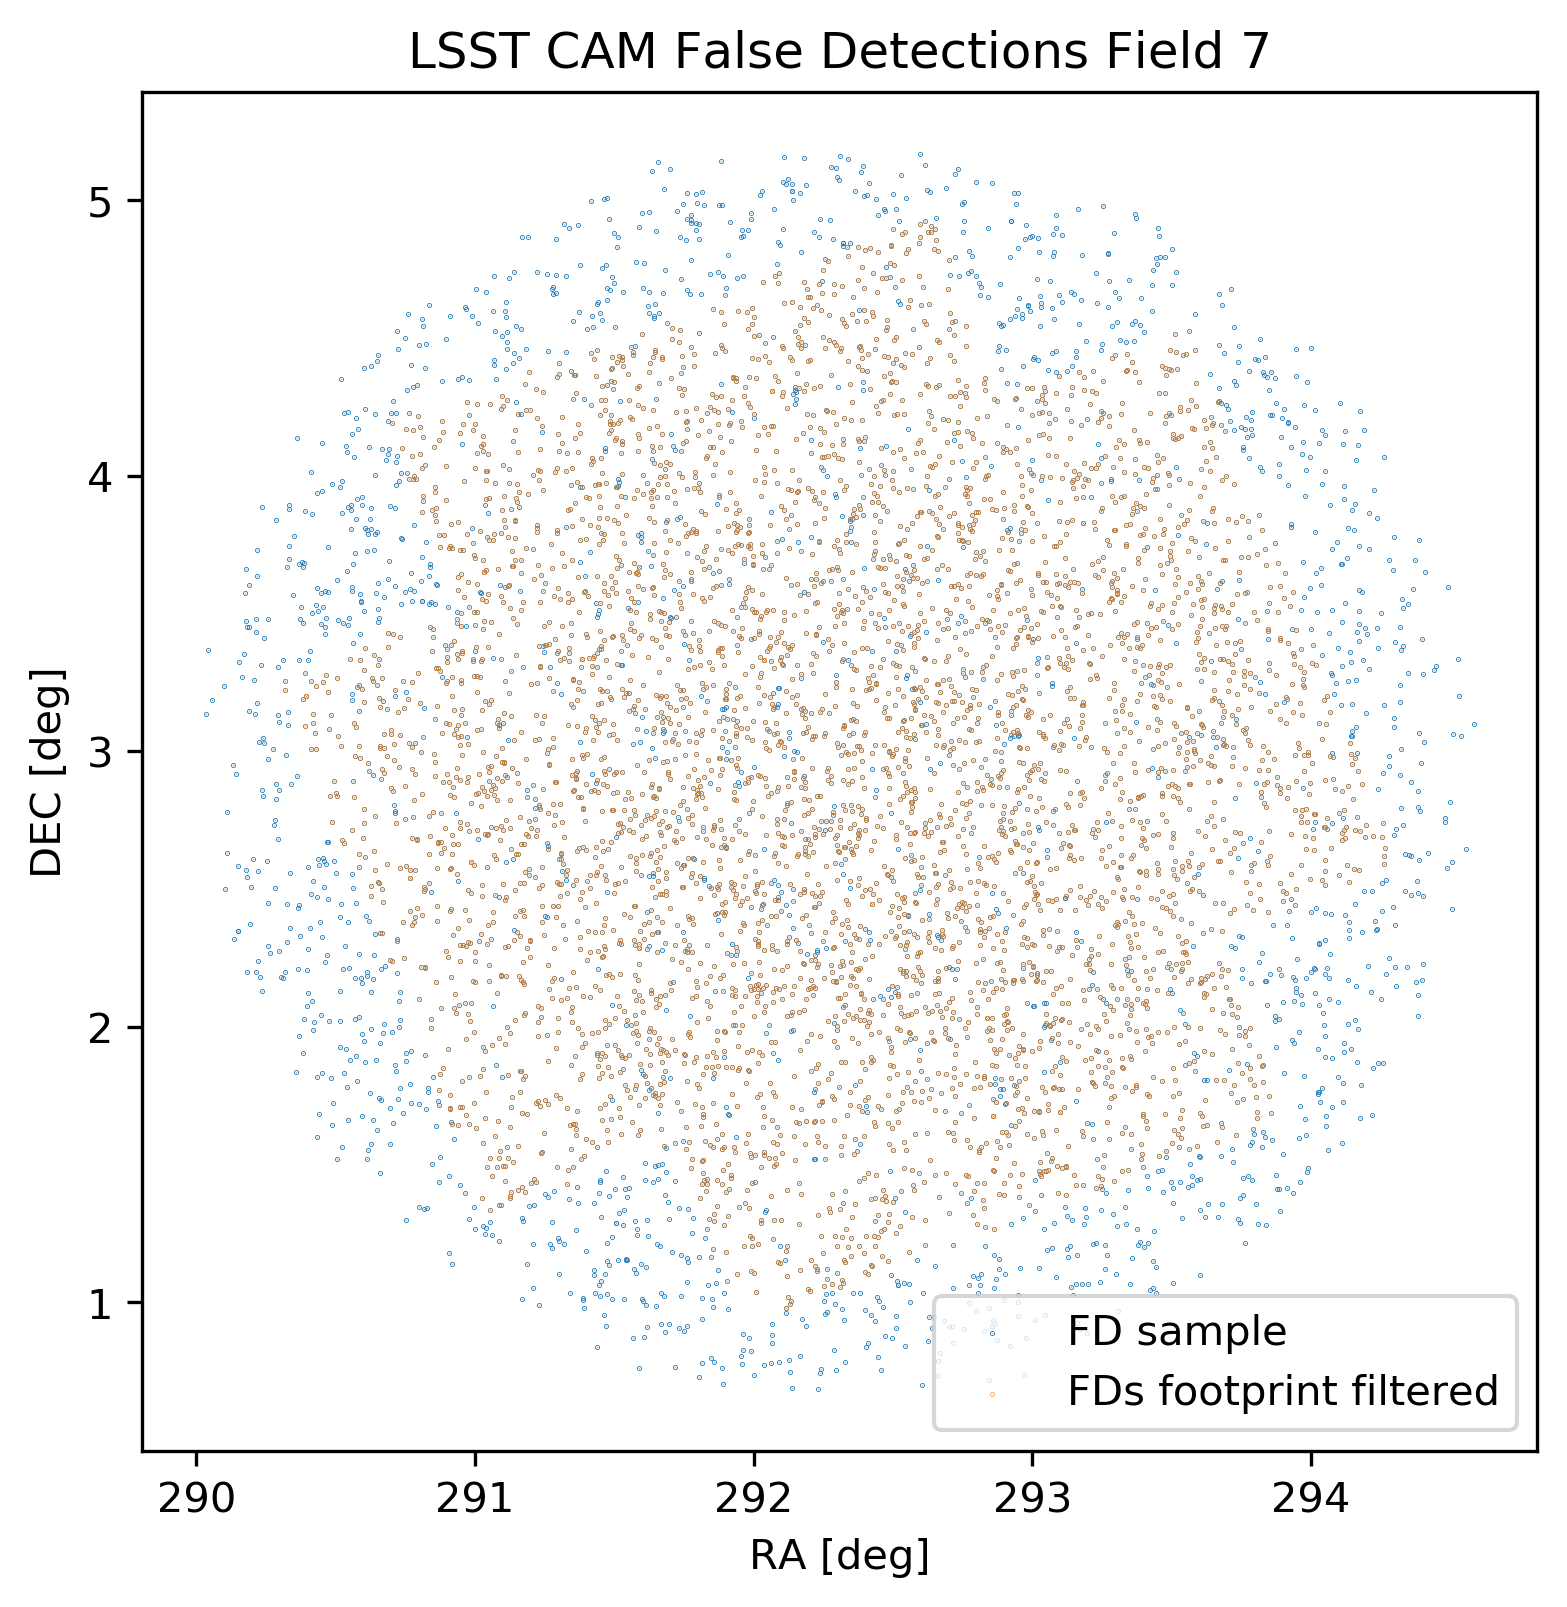

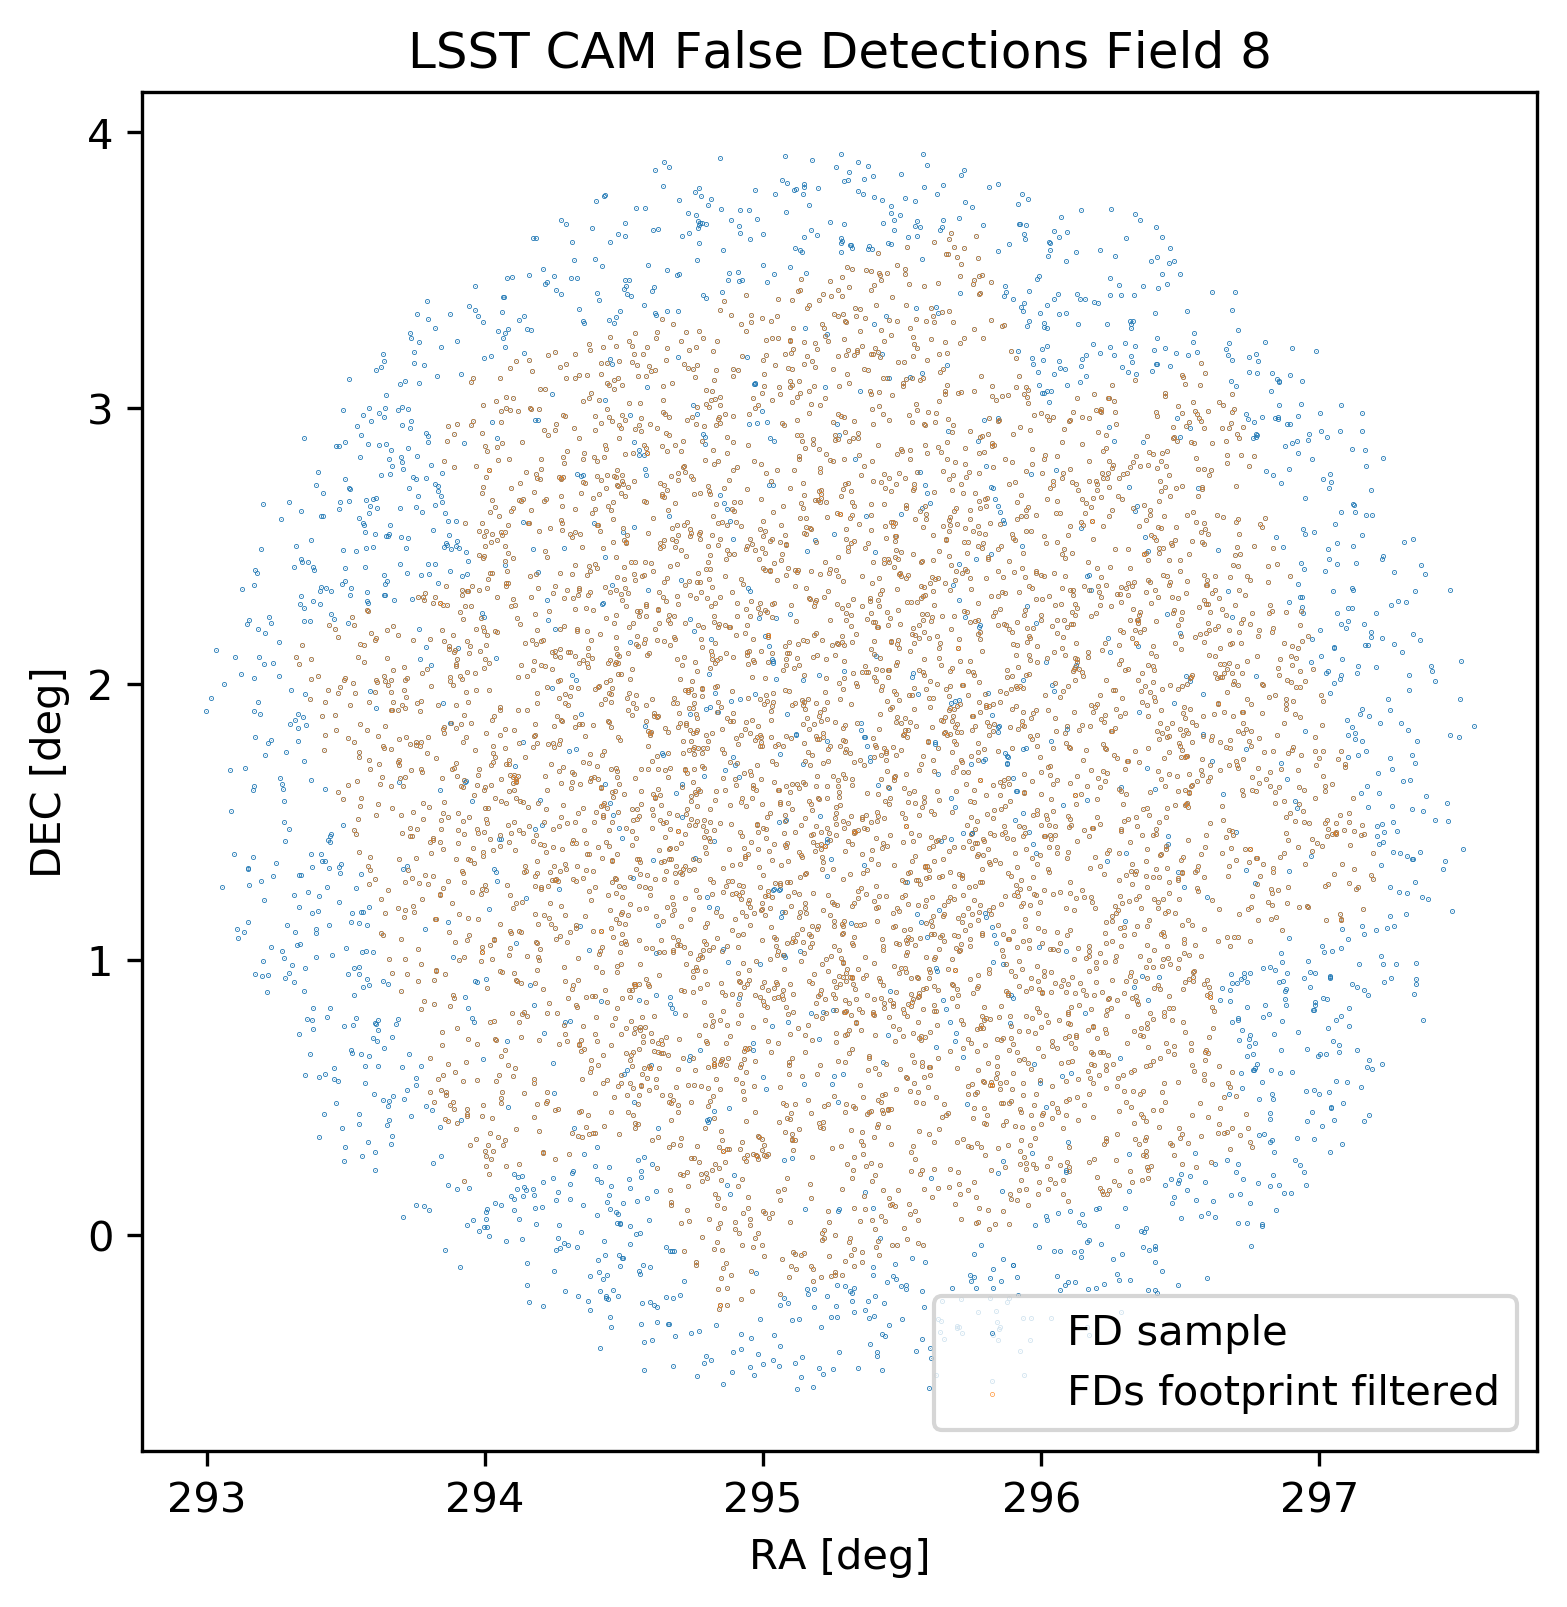

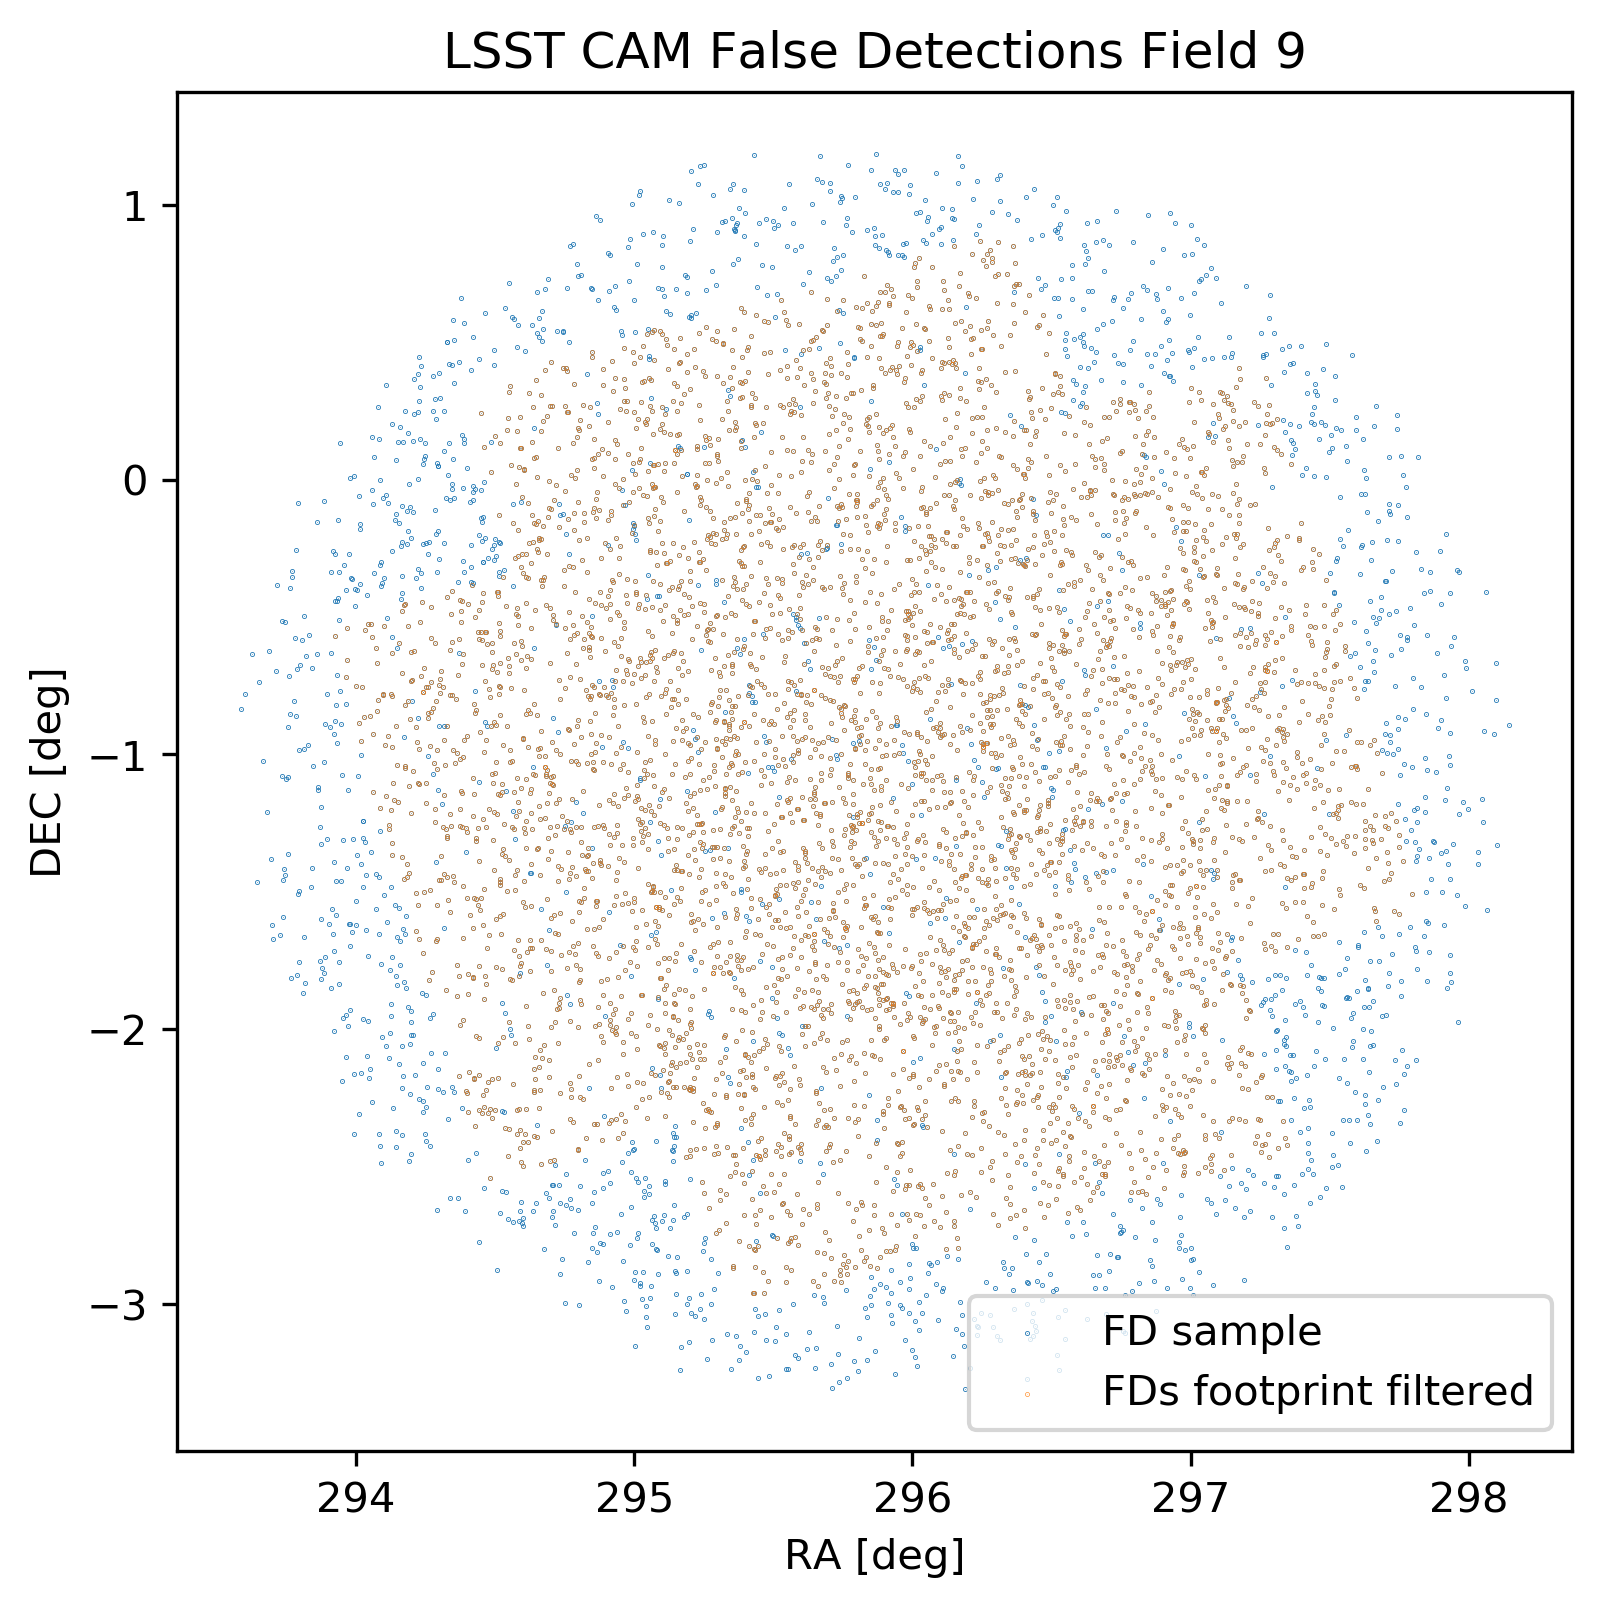

In [30]:
for n in range(10):
    FDF2=FDFiltered[FDFiltered['observationId']==n]
    FDdf2=FDdf[FDdf['observationId']==n]

    plotFilteredFootprint(FDdf2, FDF2, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='LSST CAM False Detections Field '+str(n))

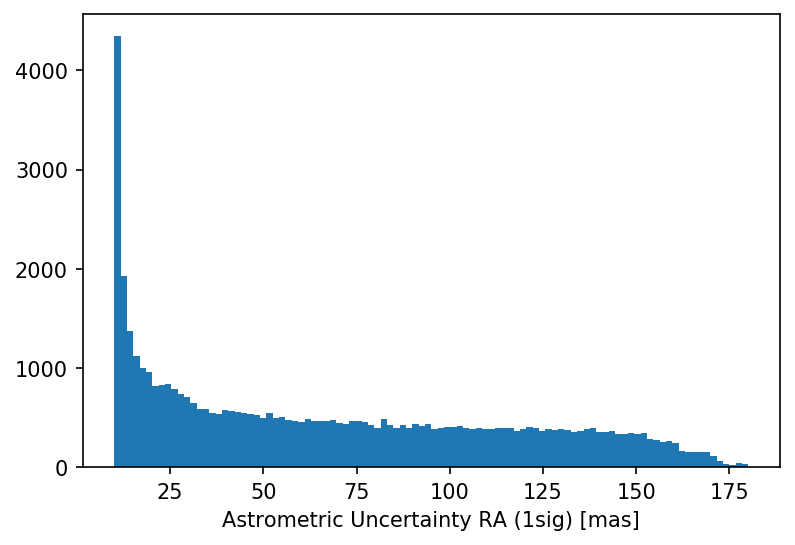

In [31]:
plt.figure(dpi=150)
plt.hist(FDFiltered['AstRASigma(mas)'], bins=100)
plt.xlabel('Astrometric Uncertainty RA (1sig) [mas]')
plt.show()

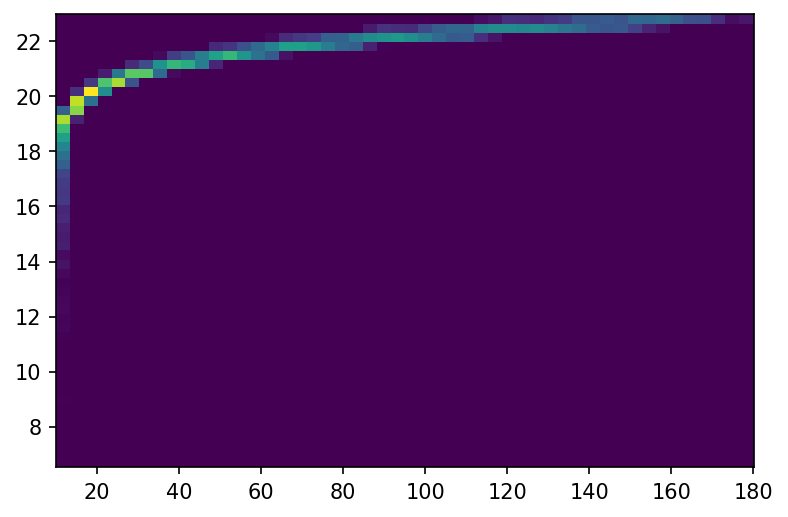

In [32]:
plt.figure(dpi=150)
plt.hist2d(FDFiltered['AstRASigma(mas)'], FDFiltered['Filtermag'], bins=50) 
plt.show()

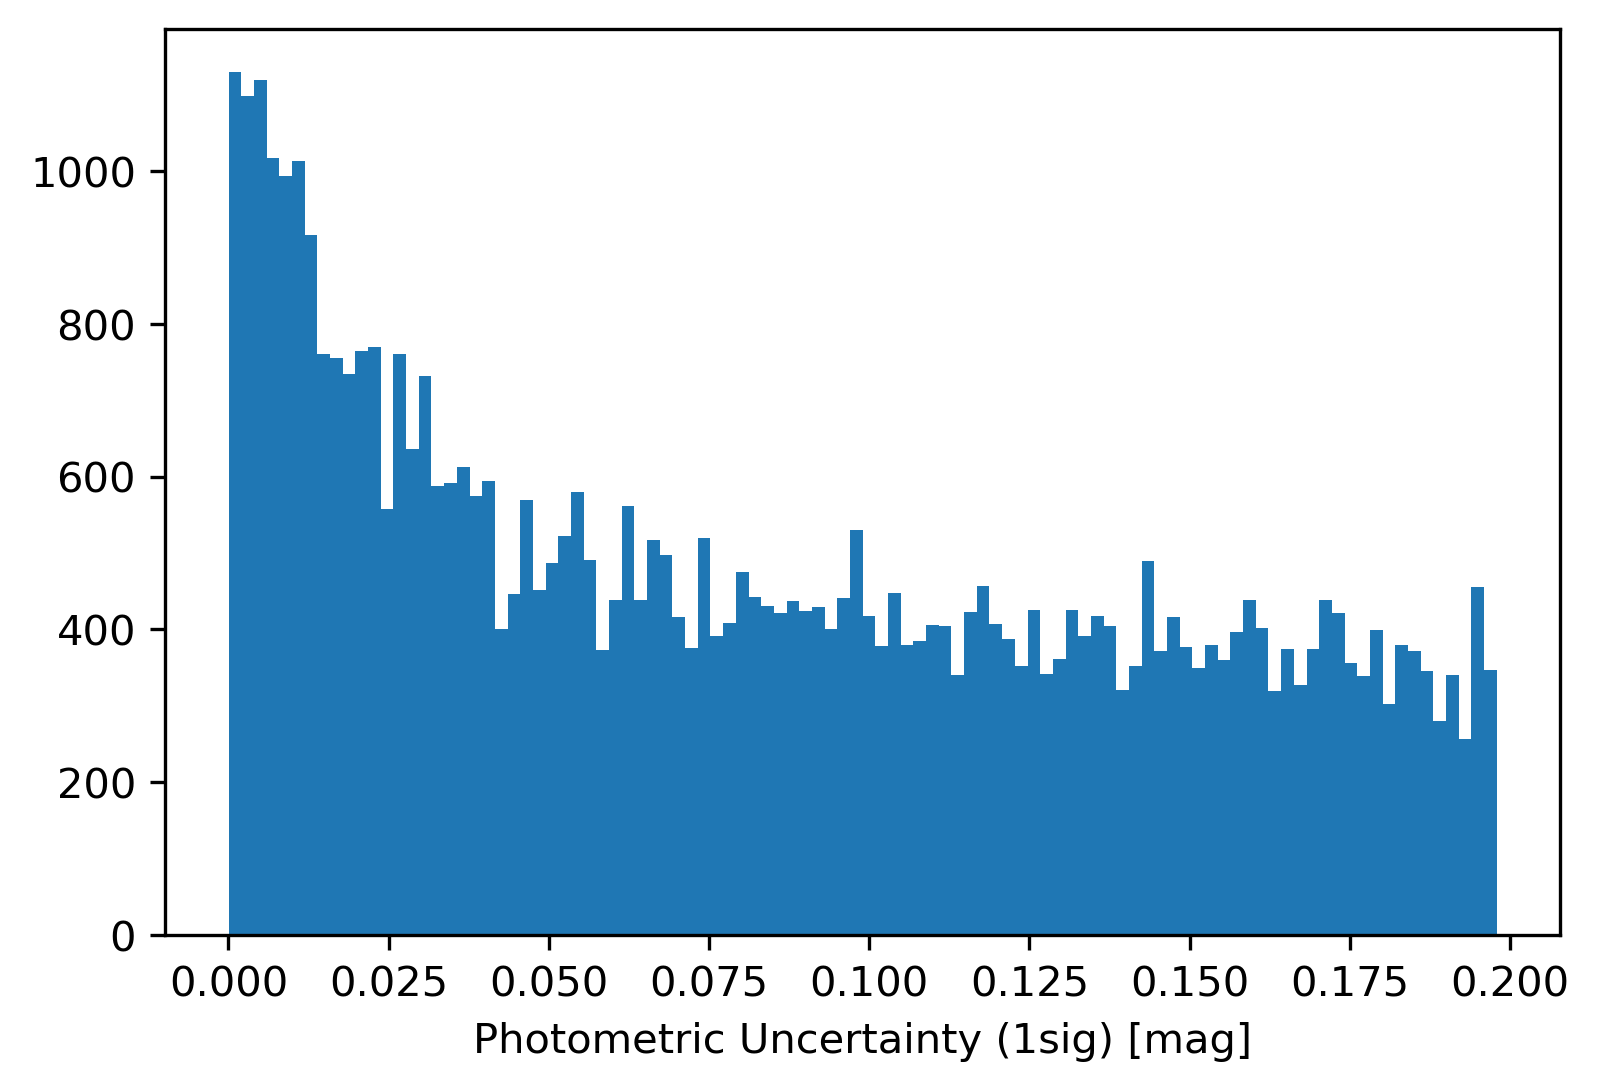

In [33]:
plt.figure(dpi=300)
plt.hist(FDFiltered['PhotometricSigma(mag)'], bins=100)
plt.xlabel('Photometric Uncertainty (1sig) [mag]')
plt.show()

In [34]:
NSdf, nNSlist=createRandomNoise(LSSTdf)

mean, sigma of number of random noise per square degree 23 , 0


In [35]:
NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')

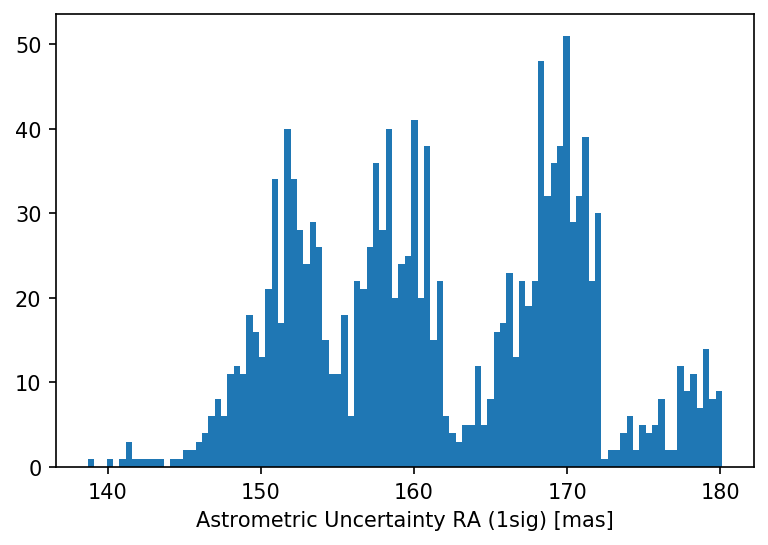

In [36]:
plt.figure(dpi=150)
plt.hist(NSFiltered['AstRASigma(mas)'], bins=100)
plt.xlabel('Astrometric Uncertainty RA (1sig) [mas]')
plt.show()

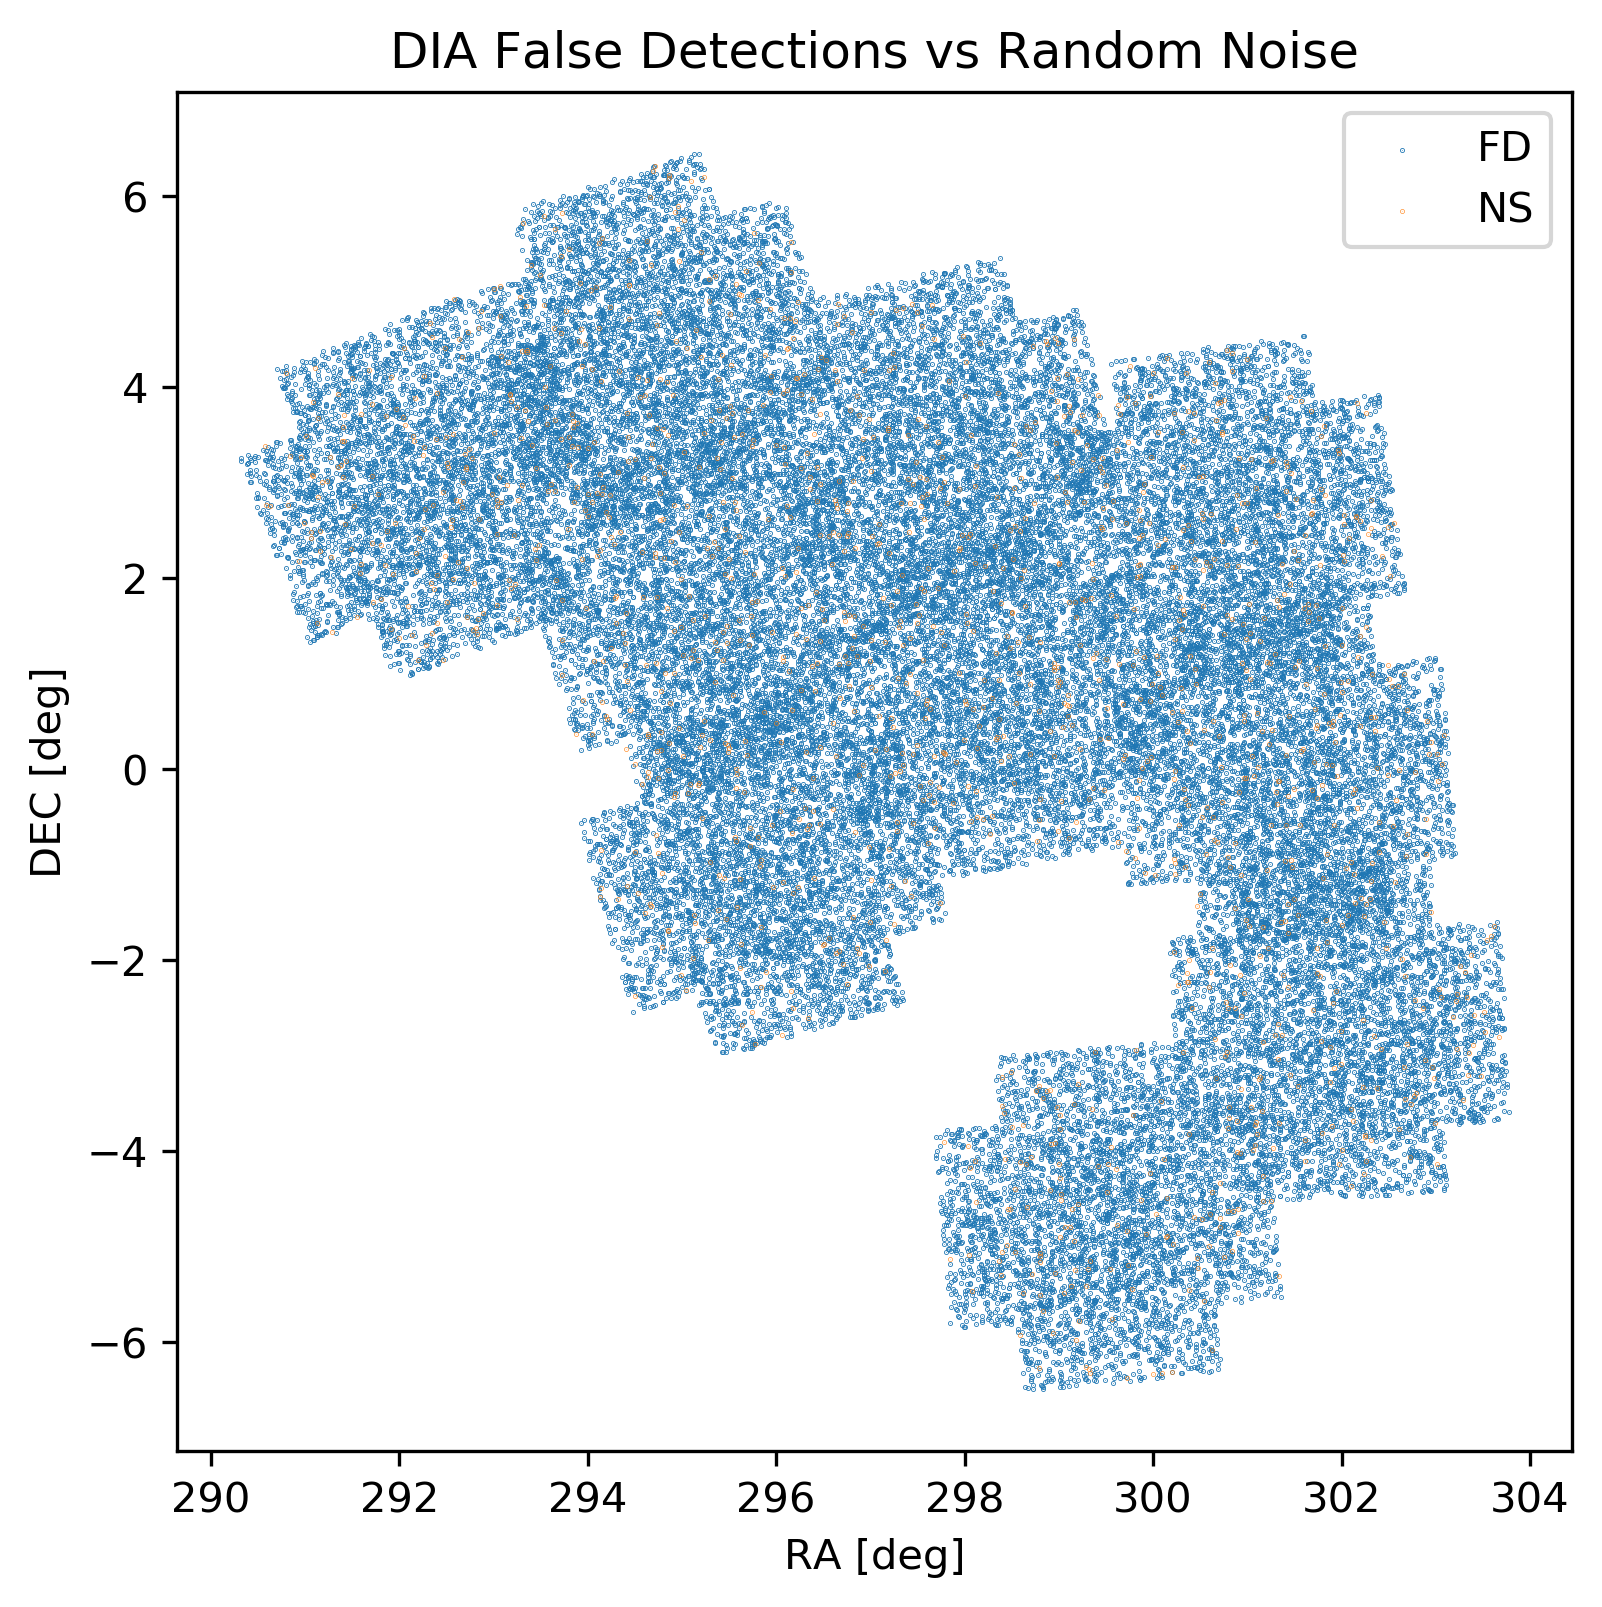

In [37]:
plotFilteredFootprint(FDFiltered, NSFiltered, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='DIA False Detections vs Random Noise', label1='FD', label2='NS')

### False Detections for LSST year 1


In [43]:
# select year 1 of LSST opsim
nrows=220000
LSSTdf=getSqlData(db_path,0,nrows)
(LSSTdf.observationStartMJD.max()-LSSTdf.observationStartMJD.min())/365

1.0526887982099378

In [44]:
delta=500
visit_range=np.arange(0,nrows,delta)

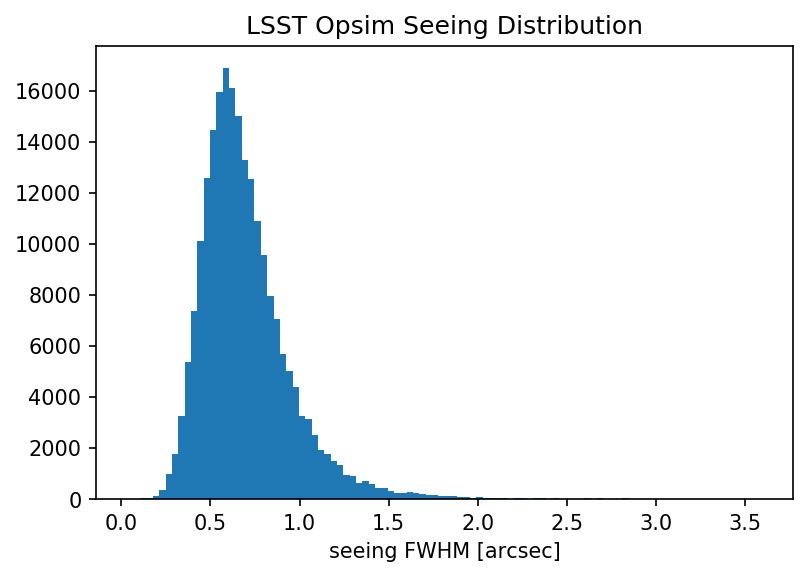

In [40]:
# Plot the seeing distribution
plt.figure(dpi=150)
plt.title('LSST Opsim Seeing Distribution')
LSSTdf.seeingFwhm500.hist(bins=100)
plt.grid(False)
plt.xlabel('seeing FWHM [arcsec]')
plt.show()

Create DIA False Detection files for the first year of LSST.

In [41]:
Parallel(n_jobs=15)(delayed(makeFalseDetectionsFiles)(i,delta,db_path, seed=i) for i in visit_range)

/epyc/projects/sssc/conda-sssc-env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

Create random noise False Detection files for the first year of LSST.

In [48]:
Parallel(n_jobs=10)(delayed(makeRandomNoiseFiles)(i,delta,db_path) for i in visit_range)

['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

In [ ]:
A quick look on the data that has been produced

In [49]:
FDtest=pd.read_csv('data/false_detections_fbs-v1_7_1-0000500.csv')

In [50]:
FDtest

ObjID  observationId      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
0          FD            500  59854.216873           NaN                 NaN   
1          FD            500  59854.216873           NaN                 NaN   
2          FD            500  59854.216873           NaN                 NaN   
3          FD            500  59854.216873           NaN                 NaN   
4          FD            500  59854.216873           NaN                 NaN   
...       ...            ...           ...           ...                 ...   
2433385    FD            999  59855.050149           NaN                 NaN   
2433386    FD            999  59855.050149           NaN                 NaN   
2433387    FD            999  59855.050149           NaN                 NaN   
2433388    FD            999  59855.050149           NaN                 NaN   
2433389    FD            999  59855.050149           NaN                 NaN   

         AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  AstDecRate(deg/day)  \
0        322.518766                 NaN   -65.306193                  NaN   
1        329.477854                 NaN   -65.159513                  NaN   
2        323.590186                 NaN   -64.166320                  NaN   
3        326.328395                 NaN   -64.596336                  NaN   
4        327.757024                 NaN   -64.095169                  NaN   
...             ...                 ...          ...                  ...   
2433385  310.177874                 NaN    -0.963151                  NaN   
2433386  309.642429                 NaN    -2.778521                  NaN   
2433387  309.157710                 NaN    -0.584838                  NaN   
2433388  308.368946                 NaN    -1.121231                  NaN   
2433389  308.119290                 NaN    -1.149588                  NaN   

         Ast-Sun(J2000x)(km)  Ast-Sun(J2000y)(km)  Ast-Sun(J2000z)(km)  \
0                        NaN                  NaN                  NaN   
1                        NaN                  NaN                  NaN   
2                        NaN                  NaN                  NaN   
3                        NaN                  NaN                  NaN   
4                        NaN                  NaN                  NaN   
...                      ...                  ...                  ...   
2433385                  NaN                  NaN                  NaN   
2433386                  NaN                  NaN                  NaN   
2433387                  NaN                  NaN                  NaN   
2433388                  NaN                  NaN                  NaN   
2433389                  NaN                  NaN                  NaN   

         Sun-Ast-Obs(deg)   V  Filtermag  V(H=0) Filter  AstRASigma(mas)  \
0                     NaN NaN  21.141915     NaN      y        86.454189   
1                     NaN NaN  21.099494     NaN      y        83.255053   
2                     NaN NaN  19.742080     NaN      y        26.855119   
3                     NaN NaN  20.748581     NaN      y        61.143313   
4                     NaN NaN  20.855885     NaN      y        67.149457   
...                   ...  ..        ...     ...    ...              ...   
2433385               NaN NaN  20.200836     NaN      y        18.448726   
2433386               NaN NaN  19.447654     NaN      y        12.994435   
2433387               NaN NaN  21.415594     NaN      y        46.146595   
2433388               NaN NaN  21.070316     NaN      y        34.581002   
2433389               NaN NaN  20.217672     NaN      y        18.637745   

         AstDecSigma(mas)  PhotometricSigma(mag)  
0               86.454189               0.121467  
1               83.255053               0.117147  
2               26.855119               0.036676  
3               61.143313               0.086720  
4               67.149457               0.095090  
...           

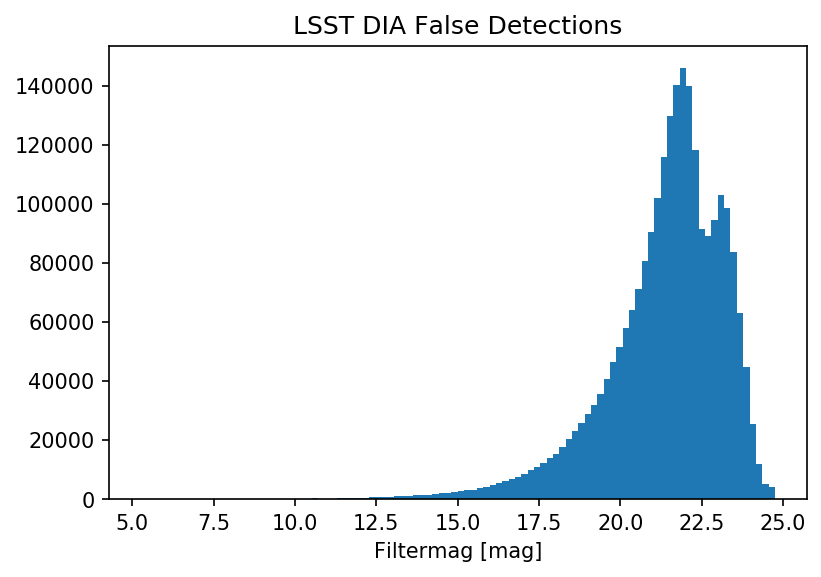

In [51]:

plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
FDtest.Filtermag.hist(bins=100)
plt.grid(False)
plt.xlabel('Filtermag [mag]')
plt.show()

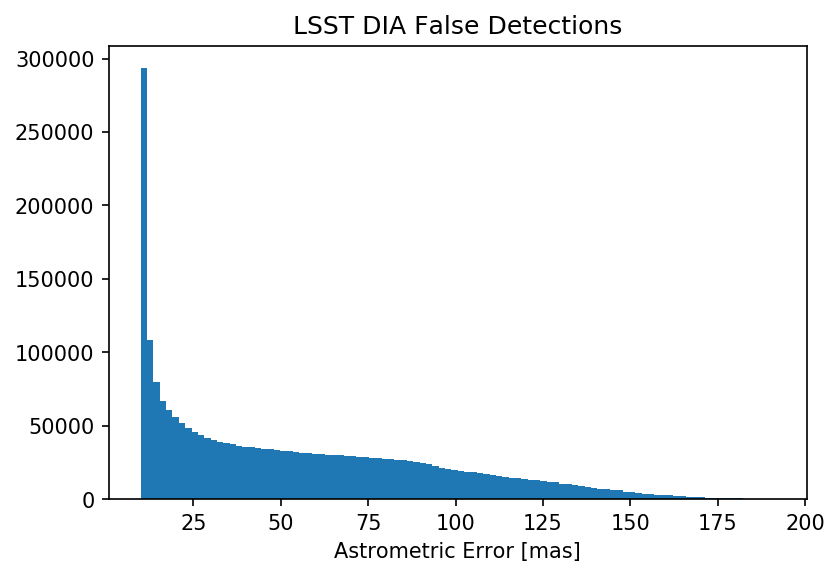

In [52]:
plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
FDtest['AstRASigma(mas)'].hist(bins=100)
plt.grid(False)
plt.xlabel('Astrometric Error [mas]')
plt.show()

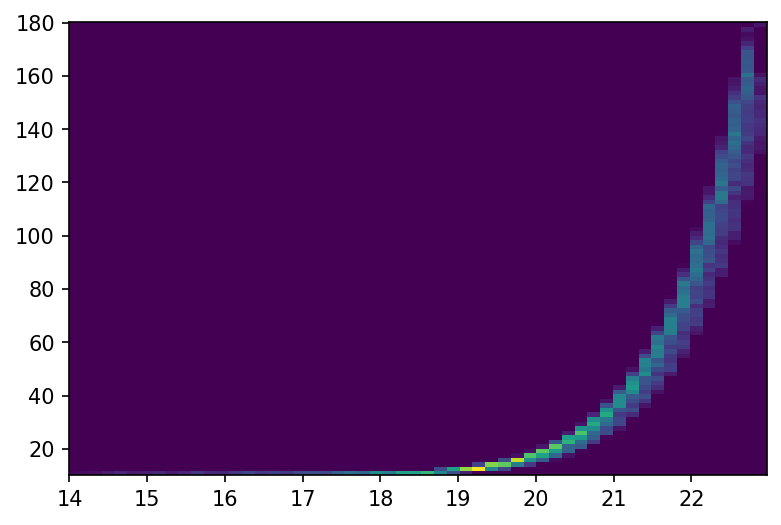

In [53]:
plt.figure(dpi=150)
plt.hist2d( FDFiltered['Filtermag'],FDFiltered['AstRASigma(mas)'], bins=100) 
plt.xlim(14)
plt.show()

In [55]:
NStest=pd.read_csv('data/random_noise_fbs-v1_7_1-0070000.csv')

In [56]:
NStest

ObjID  observationId      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
0         FD          70000  59965.200019           NaN                 NaN   
1         FD          70000  59965.200019           NaN                 NaN   
2         FD          70000  59965.200019           NaN                 NaN   
3         FD          70000  59965.200019           NaN                 NaN   
4         FD          70000  59965.200019           NaN                 NaN   
...      ...            ...           ...           ...                 ...   
232525    FD          70499  59966.102288           NaN                 NaN   
232526    FD          70499  59966.102288           NaN                 NaN   
232527    FD          70499  59966.102288           NaN                 NaN   
232528    FD          70499  59966.102288           NaN                 NaN   
232529    FD          70499  59966.102288           NaN                 NaN   

        AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  AstDecRate(deg/day)  \
0       113.665816                 NaN    -3.560354                  NaN   
1       114.846296                 NaN    -2.666738                  NaN   
2       116.416909                 NaN    -3.293658                  NaN   
3       114.123294                 NaN    -1.085555                  NaN   
4       114.973507                 NaN    -2.520206                  NaN   
...            ...                 ...          ...                  ...   
232525   67.227354                 NaN   -56.097086                  NaN   
232526   70.831815                 NaN   -56.470638                  NaN   
232527   67.762235                 NaN   -57.509488                  NaN   
232528   68.304196                 NaN   -57.946213                  NaN   
232529   68.229708                 NaN   -56.140563                  NaN   

        Ast-Sun(J2000x)(km)  Ast-Sun(J2000y)(km)  Ast-Sun(J2000z)(km)  \
0                       NaN                  NaN                  NaN   
1                       NaN                  NaN                  NaN   
2                       NaN                  NaN                  NaN   
3                       NaN                  NaN                  NaN   
4                       NaN                  NaN                  NaN   
...                     ...                  ...                  ...   
232525                  NaN                  NaN                  NaN   
232526                  NaN                  NaN                  NaN   
232527                  NaN                  NaN                  NaN   
232528                  NaN                  NaN                  NaN   
232529                  NaN                  NaN                  NaN   

        Sun-Ast-Obs(deg)   V  Filtermag  V(H=0) Filter  AstRASigma(mas)  \
0                    NaN NaN  24.331503     NaN      r        91.469450   
1                    NaN NaN  24.335181     NaN      r        91.772298   
2                    NaN NaN  24.329864     NaN      r        91.334827   
3                    NaN NaN  24.342672     NaN      r        92.392175   
4                    NaN NaN  24.327682     NaN      r        91.155949   
...                  ...  ..        ...     ...    ...              ...   
232525               NaN NaN  23.969004     NaN      u        88.544006   
232526               NaN NaN  23.970762     NaN      u        88.683872   
232527               NaN NaN  23.952754     NaN      u        87.261838   
232528               NaN NaN  23.971699     NaN      u        88.758513   
232529               NaN NaN  23.958953     NaN      u        87.748643   

        AstDecSigma(mas)  PhotometricSigma(mag)  
0              91.469450               0.195906  
1              91.772298               0.196507  
2              91.334827               0.195639  
3              92.392175               0.197735  
4              91.155949               0.195284  
...                  ...                    ...  
232525         88

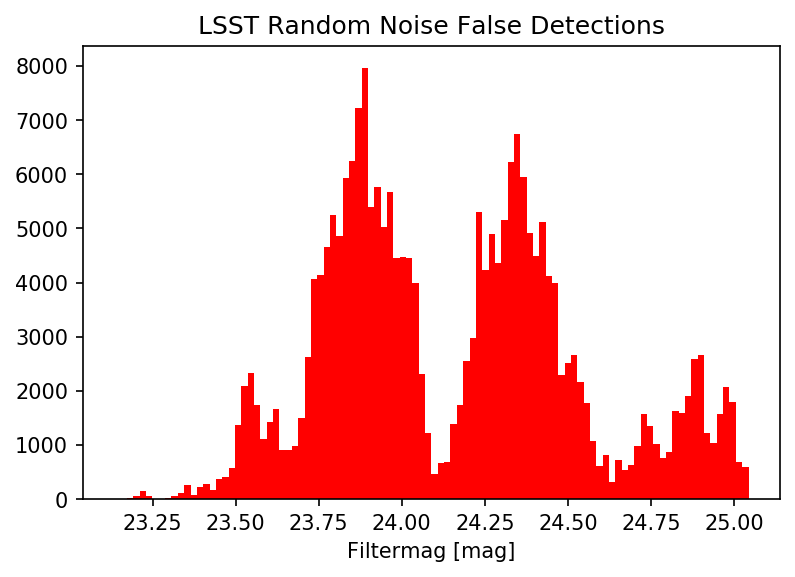

In [57]:
plt.figure(dpi=150)
plt.title('LSST Random Noise False Detections')
NStest.Filtermag.hist(bins=100, color='r')
plt.grid(False)
plt.xlabel('Filtermag [mag]')
plt.show()

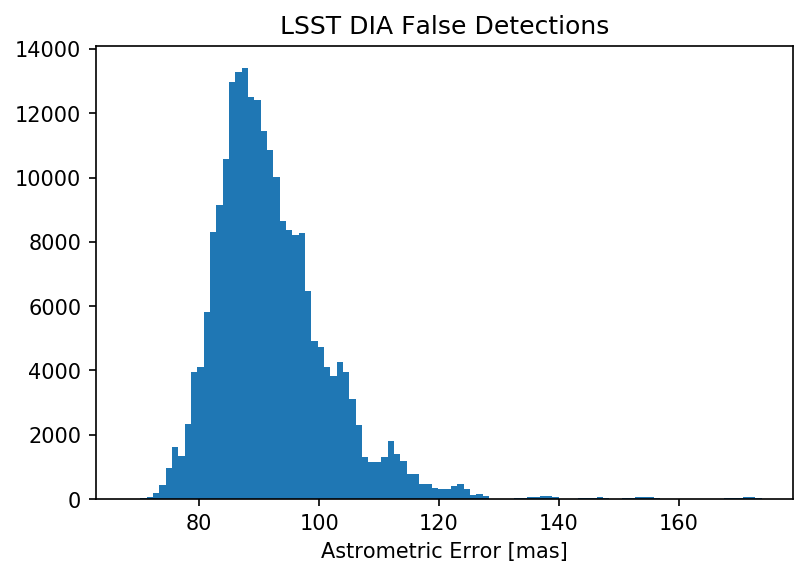

In [58]:
plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
NStest['AstRASigma(mas)'].hist(bins=100)
plt.grid(False)
plt.xlabel('Astrometric Error [mas]')
plt.show()